In [1]:
# necessary imports
from collections import defaultdict
from functools import reduce
from pathlib import Path
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import pointbiserialr
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# reading in data
acct_df = pd.read_parquet(Path('../../q2data/q2-ucsd-acctDF.pqt'))
cons_df = pd.read_parquet(Path('../../q2data/q2-ucsd-consDF.pqt'))
trxn_df = pd.read_parquet(Path('../../q2data/q2-ucsd-trxnDF.pqt'))

In [3]:
# changing column types for processing
acct_df.balance_date = pd.to_datetime(acct_df.balance_date)
acct_df = acct_df.astype({'prism_consumer_id': int, 'prism_account_id': int})

cons_df.evaluation_date = pd.to_datetime(cons_df.evaluation_date)
cons_df = cons_df.astype({'prism_consumer_id': int})

trxn_df.posted_date = pd.to_datetime(trxn_df.posted_date)
trxn_df = trxn_df.astype({'prism_consumer_id': int, 'prism_transaction_id': int})

In [ ]:
# replacing category ints with actual values
cat_mappings = pd.read_csv(Path("../../q2data/q2-ucsd-cat-map.csv"))
cat_mappings = dict(zip(cat_mappings['category_id'], cat_mappings['category']))
trxn_df.category = trxn_df.category.replace(cat_mappings)

In [4]:
display(acct_df, cons_df, trxn_df)

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0
...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN
14996,14996,2022-01-15,625.0,NaN
14997,14997,2022-01-31,688.0,NaN
14998,14998,2022-03-08,722.0,NaN


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31


In [5]:
# different account types
acct_df.account_type.value_counts()

account_type
CHECKING           15467
SAVINGS             7751
CREDIT CARD          691
LOAN                 127
LINE OF CREDIT        93
CONSUMER              73
BROKERAGE             66
CD                    45
MONEY MARKET          36
AUTO                  29
MORTGAGE              22
PREPAID               19
OTHER                 12
IRA                    9
ROTH                   5
CASH MANAGEMENT        5
401K                   4
RETIREMENT             3
STUDENT                2
HSA                    2
OVERDRAFT              2
MONEYMARKET            1
STOCK PLAN             1
HOME EQUITY            1
Name: count, dtype: int64

In [6]:
# number of consumers that hold x number of accounts
acct_df.groupby('prism_consumer_id').count().prism_account_id.value_counts()

prism_account_id
2     6038
1     5038
3     1179
4      404
5      173
6       76
7       41
8       18
9       14
10      12
11       7
12       6
14       1
13       1
25       1
Name: count, dtype: int64

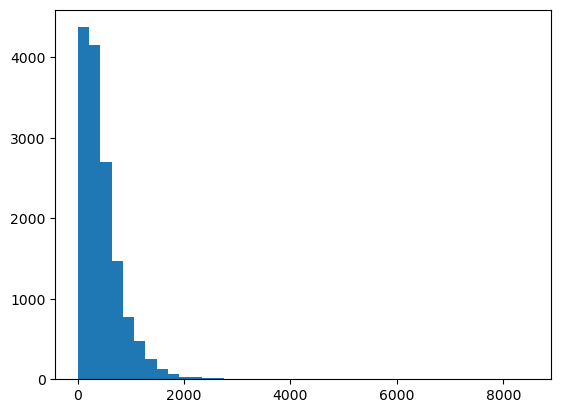

In [7]:
# distribution of number of transactions per consumer
trxn_counts = trxn_df.groupby('prism_consumer_id').count().prism_transaction_id
plt.hist(trxn_counts, bins=40)
plt.show()

In [8]:
# creating separate df for consumers with DQ_TARGET values
cons_df_no_na = cons_df[~cons_df['DQ_TARGET'].isna()]

## Week 1 

**Single best feature to predict `DQ_TARGET`**

**Simple**
- sum of a consumer's `balance`
- `credit_score` seems like an obvious one
- sum of consumer's credit - sum of consumer's debit

In [9]:
# getting outflow (debit) and inflow (credit) categories
debit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'DEBIT']['category'].value_counts().index)
credit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'CREDIT']['category'].value_counts().index)

In [10]:
# creating sum of balances feature
sum_of_balance = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                   .rename(columns={'balance': 'sum_of_balance'}).reset_index()
# use left outer join because we want features for all consumers even if it is NA for now
features_df = cons_df.merge(sum_of_balance, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [11]:
features_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,sum_of_balance
0,0,2021-09-01,726.0,0.0,320.37
1,1,2021-07-01,626.0,0.0,3302.42
2,2,2021-05-01,680.0,0.0,2805.36
3,3,2021-03-01,734.0,0.0,7667.01
4,4,2021-10-01,676.0,0.0,394.55
...,...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN,NaN
14996,14996,2022-01-15,625.0,NaN,6821.92
14997,14997,2022-01-31,688.0,NaN,NaN
14998,14998,2022-03-08,722.0,NaN,NaN


**Note: balances have different meaning based on account type, i.e. a credit card balance (outflow) vs checkings balance (inflow)**

#### Feature significance metrics

In [12]:
# r2 value for sum of balance feature #
# getting rows where neither features are NA
cons_sum_balance_df_no_na = features_df[(~features_df['DQ_TARGET'].isna()) & (~features_df['sum_of_balance'].isna())]
sum_balance_r2 = np.corrcoef(
        cons_sum_balance_df_no_na['DQ_TARGET'], 
        cons_sum_balance_df_no_na['sum_of_balance']
    )[0][1]**2
sum_balance_r2

0.0015695061588102432

In [13]:
# KS test pvalue for sum of balance feature
cons_sum_balance_dq0 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 0.0]
cons_sum_balance_dq1 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 1.0]
scipy.stats.ks_2samp(cons_sum_balance_dq0["sum_of_balance"], cons_sum_balance_dq1["sum_of_balance"]).pvalue

3.7555463168404585e-99

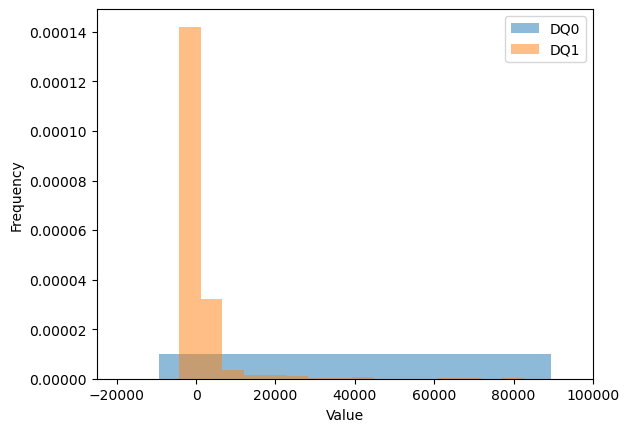

In [14]:
# plotting distributions of sum of balance for delinquent vs nondelinquent consumers
plt.hist(cons_sum_balance_dq0["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_sum_balance_dq1["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-25000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

In [15]:
# r2 value of credit score feature
credit_score_r2 = np.corrcoef(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])[0][1]**2
credit_score_r2

0.06828206045598226

In [16]:
# point biserial value for credit score feature
credit_score_pbr = scipy.stats.pointbiserialr(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])
credit_score_pbr.pvalue

1.5212196313474402e-186

In [17]:
# calculating credit_minus_debit feature
credit_minus_debit = trxn_df.groupby('prism_consumer_id') \
                            .apply(
                                lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                            - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum()
                                )

/tmp/ipykernel_354/3454179167.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [18]:
# merging credit_minus_debit feature with features_df
features_df = features_df.merge(pd.DataFrame(credit_minus_debit).reset_index() \
                                          .rename(columns={0: "credit_minus_debit"}), 
                                                 on='prism_consumer_id',
                                                 how='left')
cons_credit_minus_debit_dq0 = features_df[features_df["DQ_TARGET"] == 0.0]
cons_credit_minus_debit_dq0_no_na = cons_credit_minus_debit_dq0[~cons_credit_minus_debit_dq0["credit_minus_debit"].isna()]
cons_credit_minus_debit_dq1 = features_df[features_df["DQ_TARGET"] == 1.0]
cons_credit_minus_debit_dq1_no_na = cons_credit_minus_debit_dq1[~cons_credit_minus_debit_dq1["credit_minus_debit"].isna()]
# calculating KS stat for credit_minus_debit feature for delinquent / nondelinquent consumers
scipy.stats.ks_2samp(cons_credit_minus_debit_dq0_no_na["credit_minus_debit"], cons_credit_minus_debit_dq1_no_na["credit_minus_debit"]).pvalue

1.643182347946055e-26

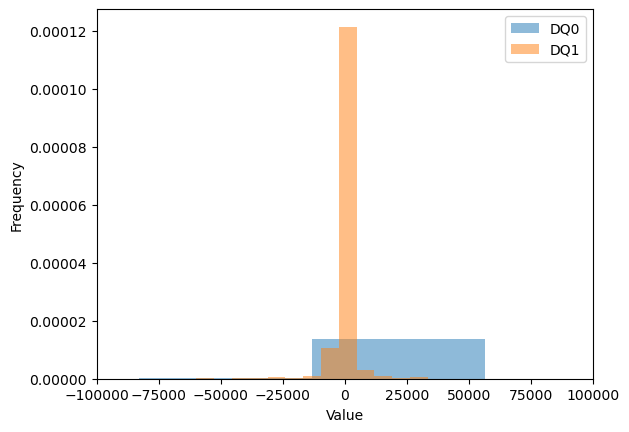

In [19]:
# # plotting distributions of credit_minus_debit for delinquent vs nondelinquent consumers
plt.hist(cons_credit_minus_debit_dq0["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_credit_minus_debit_dq1["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-100000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

## Week 2

**New balance features**
- percent change in balance from earliest date to latest date
- account balance less than 0
  
**New income features**
- number of income transactions
- standard deviation of income
- number of income sources

In [20]:
# should determine the consumers that don't appear in acct_df or trxn_df, remove them from training data

In [24]:
def calc_balance_delta(rand_cons):
    """
    Calculating change in balance from first transaction to last transaction.
    Args:
        rand_cons (int): consumer id
    Returns:
        float: change in balance
    """
    rand_cons_acct_df = acct_df[acct_df.prism_consumer_id == rand_cons]
    rand_cons_trxn_df = trxn_df[trxn_df.prism_consumer_id == rand_cons].sort_values(by='posted_date')
    
    avg_balance_date = np.mean(rand_cons_acct_df.balance_date)
    balance = sum(rand_cons_acct_df.balance)
    
    before_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date <= avg_balance_date]
    after_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date > avg_balance_date]
    
    initial_balance = balance + sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "DEBIT"].amount) - \
                               sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "CREDIT"].amount) 
    ending_balance = balance + sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "CREDIT"].amount) - \
                               sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "DEBIT"].amount) 
    if initial_balance == 0:
        return 1
    else:
        return ((ending_balance - initial_balance) / initial_balance)

In [128]:
def create_inflows_outflows_features(trxn_df):
    # creating relevant outflows df with only expenses
    debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
    credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX
    
    outflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'DEBIT') & (~trxn_df['category'].isin(debits_not_expenses))] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_agg_df.columns = ['OUTFLOWS_amt_' + col for col in outflows_agg_df.columns]
    inflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'CREDIT') & (~trxn_df['category'].isin(credits_not_income))] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_agg_df.columns = ['INFLOWS_amt_' + col for col in inflows_agg_df.columns]
    
    ### creating filtered window transactions dfs for inflows and outflows ###
    trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
    trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
    trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
    trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
    trxn_df_last_year = filter_time_window(trxn_df, years=1)

    # grabbing debits and credits across time periods
    debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
    debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
    debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
    debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
    debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']
    
    credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
    credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
    credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
    credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
    credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

    # creating windowed expenses aggregate metrics
    outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_14_days_agg_df.columns = ['OUTFLOWS_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]
    
    outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_30_days_agg_df.columns = ['OUTFLOWS_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]
    
    outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_3_months_agg_df.columns = ['OUTFLOWS_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]
    
    outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_6_months_agg_df.columns = ['OUTFLOWS_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]
    
    outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    outflows_last_year_agg_df.columns = ['OUTFLOWS_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

    # creating windowed inflows aggregate metrics
    inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_14_days_agg_df.columns = ['INFLOWS_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]
    
    inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_30_days_agg_df.columns = ['INFLOWS_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]
    
    inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_3_months_agg_df.columns = ['INFLOWS_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]
    
    inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_6_months_agg_df.columns = ['INFLOWS_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]
    
    inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
    inflows_last_year_agg_df.columns = ['INFLOWS_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

    all_outflows_dfs = [
                             outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                             outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df,
                         ]

    all_inflows_dfs = [
                             inflows_agg_df, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df,
                             inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df,
                         ]

    return all_outflows_dfs, all_inflows_dfs

In [130]:
def create_binary_features(trxn_df):
    # creating flags for risky categories
    risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it # TODO ADD OVERDRAFT
    trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
    
    gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
    bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
    overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

    return [gambling_flag_df, bnpl_flag_df, overdraft_flag_df]

In [133]:
def create_features_df(cons_df, acct_df, trxn_df, exclude=False):
    # if we want to do scoring exclusions, then have new cons_df with filtered consumers
    if exclude:
        cons_df = exclude_consumers(cons_df, acct_df, trxn_df)
        
    # creating sum of balances feature
    sum_of_balance = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                       .rename(columns={'balance': 'sum_of_balance'}).reset_index()
    # use left outer join because we want features for all consumers even if it is NA for now
    features_df = cons_df.merge(sum_of_balance, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

    # create balance deltas
    balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)
    balance_delta_df = pd.DataFrame(balance_deltas).reset_index() \
                                               .rename(columns=
                                                       {'index': 'prism_consumer_id', 
                                                        'prism_consumer_id': 'balance_delta'}
                                                      )
    features_df = features_df.merge(balance_delta_df, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

    # number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
    num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
    num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                    .rename(columns=
                                            {'index': 'prism_consumer_id', 
                                             'category': 'num_income_source'}
                                           )

    
    all_outflows_dfs, all_inflows_dfs = create_inflows_outflows_features(trxn_df)
    binary_features_dfs = create_binary_features(trxn_df)
    balance_features_df, category_features_df = read_other_data('balance_ftrs.csv', 'category_features.csv')
    
    # merging outflows and inflows across time periods into features df
    features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                         [cons_df, sum_of_balance, balance_delta_df, num_income_source_df, balance_features_df, category_features_df] + 
                         all_outflows_dfs + all_inflows_dfs + binary_features_dfs
                        )
 
    return features_df

In [25]:
# growth in balance for each consumer
balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)

CPU times: user 5min 21s, sys: 2.58 s, total: 5min 24s
Wall time: 1min 53s


In [26]:
# creating balance_delta dataframe and merging with other features generated
balance_delta_df = pd.DataFrame(balance_deltas).reset_index() \
                                               .rename(columns=
                                                       {'index': 'prism_consumer_id', 
                                                        'prism_consumer_id': 'balance_delta'}
                                                      )
features_df = features_df.merge(balance_delta_df, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [27]:
# number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                .rename(columns=
                                        {'index': 'prism_consumer_id', 
                                         'category': 'num_income_source'}
                                       )
num_income_source_df

,prism_consumer_id,num_income_source
0,0,7
1,1,6
2,2,8
3,3,9
4,4,5
...,...,...
14471,14995,6
14472,14996,6
14473,14997,5
14474,14998,10


In [29]:
# merging num_income_source and std_income features
features_df = features_df.merge(num_income_source_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(std_income_df, on='prism_consumer_id', how='left')
features_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,INFLOWS_std
0,0,2021-09-01,726.0,0.0,320.37,-521.59,-0.379272,7.0,494.177258
1,1,2021-07-01,626.0,0.0,3302.42,1805.43,3.245659,6.0,383.271173
2,2,2021-05-01,680.0,0.0,2805.36,430.13,0.203075,8.0,609.314103
3,3,2021-03-01,734.0,0.0,7667.01,2795.24,0.481150,9.0,844.130789
4,4,2021-10-01,676.0,0.0,394.55,-2543.60,-1.421784,5.0,368.114382
...,...,...,...,...,...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN,NaN,-543.80,1.000000,6.0,329.312758
14996,14996,2022-01-15,625.0,NaN,6821.92,878.01,0.147716,6.0,1076.542076
14997,14997,2022-01-31,688.0,NaN,NaN,163.74,1.000000,5.0,2448.997302
14998,14998,2022-03-08,722.0,NaN,NaN,413.80,1.000000,10.0,1701.940647


In [30]:
# creating separate features df for non-NA DQ_TARGET rows
features_df_no_na = features_df[~features_df.DQ_TARGET.isna()]

In [31]:
features_df.shape

(15000, 9)

**NEXT STEPS**
- begin considering category nuances
- more specific time recurrence

## Week 3

In [33]:
def filter_time_window(df, days=None, months=None, years=None):
    """
    Filters transactions for each consumer over some time period
    Args:
        df (pd.DataFrame): dataframe to window over 
        days (int): number of days to go back
        months (int): number of months to go back
        years (int): number of years to go back
    Returns:
        pd.DataFrame: windowed dataframe
    """
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

In [34]:
# creating relevant outflows df with only expenses
debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX

outflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'DEBIT') & (~trxn_df['category'].isin(debits_not_expenses))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_agg_df.columns = ['OUTFLOWS_amt_' + col for col in outflows_agg_df.columns]
inflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'CREDIT') & (~trxn_df['category'].isin(credits_not_income))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_agg_df.columns = ['INFLOWS_amt_' + col for col in inflows_agg_df.columns]

In [35]:
### creating filtered window transactions dfs for inflows and outflows ###
trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
trxn_df_last_year = filter_time_window(trxn_df, years=1)

/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated o

In [36]:
# grabbing debits and credits across time periods
debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']

credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

In [37]:
# creating windowed expenses aggregate metrics
outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_14_days_agg_df.columns = ['OUTFLOWS_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]

outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_30_days_agg_df.columns = ['OUTFLOWS_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]

outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_3_months_agg_df.columns = ['OUTFLOWS_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]

outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_6_months_agg_df.columns = ['OUTFLOWS_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]

outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_year_agg_df.columns = ['OUTFLOWS_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

In [38]:
# creating windowed expenses aggregate metrics
inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_14_days_agg_df.columns = ['INFLOWS_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]

inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_30_days_agg_df.columns = ['INFLOWS_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]

inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_3_months_agg_df.columns = ['INFLOWS_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]

inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_6_months_agg_df.columns = ['INFLOWS_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]

inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_year_agg_df.columns = ['INFLOWS_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

In [39]:
# combining outflows across time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                         outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df,
                     ])

In [40]:
# combining inflows across time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, inflows_agg_df, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df,
                         inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df,
                     ])

In [41]:
# creating flags for risky categories
risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it # TODO ADD OVERDRAFT
trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

In [42]:
# combining risky flags into features df
features_df = features_df.merge(gambling_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(bnpl_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(overdraft_flag_df, on='prism_consumer_id', how='left')
features_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,INFLOWS_std,OUTFLOWS_amt_mean,...,INFLOWS_amt_last_6_months_min,INFLOWS_amt_last_6_months_max,INFLOWS_amt_last_year_mean,INFLOWS_amt_last_year_std,INFLOWS_amt_last_year_median,INFLOWS_amt_last_year_min,INFLOWS_amt_last_year_max,GAMBLING,BNPL,OVERDRAFT
0,0,2021-09-01,726.0,0.0,320.37,-521.59,-0.379272,7.0,494.177258,39.480227,...,0.02,1400.00,419.119310,523.059901,49.25,0.02,1400.00,0.0,0.0,0.0
1,1,2021-07-01,626.0,0.0,3302.42,1805.43,3.245659,6.0,383.271173,41.397870,...,0.07,1400.00,509.625161,476.805740,747.81,0.07,1400.00,0.0,1.0,0.0
2,2,2021-05-01,680.0,0.0,2805.36,430.13,0.203075,8.0,609.314103,36.461969,...,0.02,4694.48,227.158437,868.028778,0.42,0.02,4694.48,0.0,0.0,0.0
3,3,2021-03-01,734.0,0.0,7667.01,2795.24,0.481150,9.0,844.130789,51.027282,...,0.12,4398.00,493.122308,942.228631,0.77,0.12,4398.00,0.0,0.0,0.0
4,4,2021-10-01,676.0,0.0,394.55,-2543.60,-1.421784,5.0,368.114382,45.212308,...,0.02,760.00,431.771786,378.225565,460.00,0.02,1060.00,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN,NaN,-543.80,1.000000,6.0,329.312758,50.569211,...,13.13,1321.53,350.099722,363.655046,200.00,13.13,1321.53,0.0,1.0,0.0
14996,14996,2022-01-15,625.0,NaN,6821.92,878.01,0.147716,6.0,1076.542076,87.960888,...,0.01,2000.00,525.609667,559.338703,347.01,0.01,2480.00,0.0,0.0,0.0
14997,14997,2022-01-31,688.0,NaN,NaN,163.74,1.000000,5.0,2448.997302,106.366888,...,0.82,1734.41,355.277015,542.546192,12.00,0.82,1734.41,1.0,0.0,0.0
14998,14998,2022-03-08,722.0,NaN,NaN,413.80,1.000000,10.0,1701.940647,56.062056,...,9.99,3084.03,757.206183,2152.217838,255.36,9.99,20706.00,1.0,1.0,1.0


In [43]:
# what it should be: ((15000, 72), True)
features_df.shape, 'GAMBLING' in features_df.columns

((15000, 72), True)

In [44]:
# pulling in balance features (aman) and category features (tracy)
balance_features_df = pd.read_csv('balance_ftrs.csv')
category_features_df = pd.read_csv('category_features.csv')

In [45]:
final_features_df = features_df.merge(balance_features_df, on='prism_consumer_id', how='left')

In [46]:
final_features_df = final_features_df.merge(category_features_df, on='prism_consumer_id', how='left')

In [47]:
final_features_df = final_features_df.drop(columns=['evaluation_date', 'credit_score']) # drop credit score
final_features_df = final_features_df[~final_features_df['DQ_TARGET'].isna()].fillna(0)

In [48]:
final_features_df

,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,INFLOWS_std,OUTFLOWS_amt_mean,OUTFLOWS_amt_std,OUTFLOWS_amt_median,OUTFLOWS_amt_min,...,PENSION_last_6_months_std,PENSION_last_6_months_max,PENSION_last_6_months_min,PENSION_last_6_months_count,PENSION_last_year_mean,PENSION_last_year_median,PENSION_last_year_std,PENSION_last_year_max,PENSION_last_year_min,PENSION_last_year_count
0,0.0,320.37,-521.59,-0.379272,7.0,494.177258,39.480227,67.764723,20.000,1.08,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,3302.42,1805.43,3.245659,6.0,383.271173,41.397870,124.649452,19.280,0.92,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,2805.36,430.13,0.203075,8.0,609.314103,36.461969,66.402281,15.335,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,7667.01,2795.24,0.481150,9.0,844.130789,51.027282,68.022199,27.600,0.72,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,394.55,-2543.60,-1.421784,5.0,368.114382,45.212308,58.783697,25.870,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.0,1028.80,844.51,4.582506,4.0,72.440995,0.000000,0.000000,0.000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13996,0.0,11495.77,-321.80,-0.027231,9.0,680.179827,90.099577,309.556912,35.000,1.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13997,0.0,2396.85,47.76,0.020331,6.0,562.410612,825.034444,1207.119639,87.030,0.90,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13998,0.0,14835.71,9486.36,1.773367,8.0,1559.836439,106.514343,528.716026,10.000,0.01,...,49.074773,1527.0,1442.0,3.0,1470.333333,1442.0,49.074773,1527.0,1442.0,3.0


In [49]:
# (12000, 1895), True
final_features_df.shape, 'GAMBLING' in final_features_df.columns

((12000, 1894), True)

In [50]:
# currently using train test split -- need to start using train val test split
X_train, X_test, y_train, y_test = train_test_split(
    final_features_df.drop(columns=['prism_consumer_id', 'DQ_TARGET']), final_features_df['DQ_TARGET'], test_size=0.2, random_state=42
)

In [51]:
def fit_model(X_train, y_train, model_type):
    """
    Fits a machine learning model based on the specified type.

    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): True training values
        model_type (str): Type of model to fit ('log_reg', REST TBD 'random_forest', 'xgboost', 'svm', 'multnb').

    Returns:
        model: Trained model.

    Saves:
        {model_type}_{train/test}_cm.png: confusion matrix of model's accuracy for train and test predictions.
    """

    ###############################
    ## MODEL TRAIN BY MODEL TYPE ##
    ###############################
    
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train, y_train) # TODO: hyperparameter config
    return model

In [52]:
def predict(X, y, model, proba=True, le=None):
    """
    Makes predictions using the trained model and evaluates accuracy.

    Args:
        X (pd.DataFrame): Features for prediction.
        y (pd.Series): True labels to compare predictions.
        model: Trained model (LogisticRegression, RandomForestClassifier, or XGBClassifier).
        proba (bool): True if you want to return the prediction probabilities, else False
        le (LabelEncoder, optional): Label encoder, required for 'xgboost' model.

    Returns:
        preds (numpy.ndarray): Predicted labels.
    """
    preds = model.predict(X)
    if proba:
        preds_proba = model.predict_proba(X)
        return preds, preds_proba
    return preds
    
    # if isinstance(model, XGBClassifier):
    #     preds_encoded = model.predict(X)
    #     preds = le.inverse_transform(preds_encoded)    

In [53]:
def evaluate_model(y, y_pred, y_pred_proba):
    # train metrics
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

In [54]:
model = fit_model(X_train, y_train, 'log_reg')

In [55]:
y_pred_train, y_pred_proba_train = predict(X_train, y_train, model)
y_pred_proba_train = y_pred_proba_train[:, 1]

In [56]:
# train metrics
evaluate_model(y_train, y_pred_train, y_pred_proba_train)

ROC AUC Score: 0.4966
Accuracy: 0.5696

Confusion Matrix:
[[5043 3759]
 [ 373  425]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.57      0.71      8802
         1.0       0.10      0.53      0.17       798

    accuracy                           0.57      9600
   macro avg       0.52      0.55      0.44      9600
weighted avg       0.86      0.57      0.66      9600



In [57]:
y_pred_test, y_pred_proba_test = predict(X_test, y_test, model)
y_pred_proba_test = y_pred_proba_test[:, 1]

In [58]:
# test metrics
evaluate_model(y_test, y_pred_test, y_pred_proba_test)

ROC AUC Score: 0.5126
Accuracy: 0.5854

Confusion Matrix:
[[1281  911]
 [  84  124]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72      2192
         1.0       0.12      0.60      0.20       208

    accuracy                           0.59      2400
   macro avg       0.53      0.59      0.46      2400
weighted avg       0.87      0.59      0.68      2400



In [59]:
feature_weights = list(zip(model.coef_[0], model.feature_names_in_))
feature_weights.sort(reverse=True, key=lambda x: abs(x[0]))

### Week 5

#### Standardization

In [60]:
# Standardize features dataset
# features i should not standardize -- all binary features (GAMBLING, BNPL, OVERDRAFT)

In [61]:
def standardize(X_train, X_test):
    # instantiate StandardScaler() to standardize features, excluding binary features
    scaler = StandardScaler()
    exclude_columns_standardize = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # binary features that shouldn't be standardized
    standardize_features = X_train.columns.difference(exclude_columns_standardize)
    
    transformer = ColumnTransformer([
        ('std_scaler', StandardScaler(), standardize_features)  # Standardize all except excluded ones
    ], remainder='passthrough')
    
    X_train_standardized = transformer.fit_transform(X_train)
    X_train_standardized = pd.DataFrame(X_train_standardized, columns=list(standardize_features) + exclude_columns_standardize)

    # standardize test features
    X_test_standardized = transformer.transform(X_test)
    X_test_standardized = pd.DataFrame(X_test_standardized, columns=list(standardize_features) + exclude_columns_standardize)

    return X_train_standardized, X_test_standardized

In [62]:
X_train_standardized, X_test_standardized = standardize(X_train, X_test)

In [63]:
# fit log reg model on train set standardized features
model_standardized = fit_model(X_train_standardized, y_train, 'log_reg')
%time y_pred_train_standardized, y_pred_proba_train_standardized = predict(X_train_standardized, y_train, model_standardized)
y_pred_proba_train_standardized = y_pred_proba_train_standardized[:, 1]

CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 223 ms


In [64]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized, y_pred_proba_train_standardized)

ROC AUC Score: 0.8902
Accuracy: 0.9279

Confusion Matrix:
[[8761   41]
 [ 651  147]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      8802
         1.0       0.78      0.18      0.30       798

    accuracy                           0.93      9600
   macro avg       0.86      0.59      0.63      9600
weighted avg       0.92      0.93      0.91      9600



In [65]:
# fit log reg model on test set standardized features
y_pred_test_standardized, y_pred_proba_test_standardized = predict(X_test_standardized, y_test, model_standardized)
y_pred_proba_test_standardized = y_pred_proba_test_standardized[:, 1]

In [66]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized, y_pred_proba_test_standardized)

ROC AUC Score: 0.6729
Accuracy: 0.8904

Confusion Matrix:
[[2128   64]
 [ 199    9]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      2192
         1.0       0.12      0.04      0.06       208

    accuracy                           0.89      2400
   macro avg       0.52      0.51      0.50      2400
weighted avg       0.85      0.89      0.87      2400



#### Feature Selection
- L1 lasso regularization
    - skip redundant features
- point biserial correlation
- recursive feature elimination (uses model coefficients w/o lasso)
     - takes a long time, starts with the initial subset of features and removes least important features recursively until target is reached

In [74]:
from sklearn.feature_selection import SelectFromModel, RFE

##### L1 lasso feature selection

In [75]:
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
model_l1.fit(X_train_standardized, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [76]:
def get_lasso_features(X_train, y_train):
    model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1) # can test different Cs
    model_l1.fit(X_train, y_train)

    feature_coefs = list(zip(model_l1.feature_names_in_, model_l1.coef_[0]))
    feature_coefs.sort(key=lambda x: abs(x[1]), reverse=True)
    return feature_coefs
    
    # # get top features after lasso regularization and make new train and test set
    # selector = SelectFromModel(model_l1, prefit=True, threshold=-np.inf, max_features=max_features)
    # top_features_l1 = list(X_train.columns[selector.get_support()])
    # X_train_l1 = X_train[top_features_l1]
    # X_test_l1 = X_test[top_features_l1]
    # return X_train_l1, X_test_l1, top_features_l1

In [77]:
def extract_category(feature_name):
    """Extracts the category from a feature name using regex."""
    match = re.match(r'^([A-Z]+(?:_[A-Z]+)*)', feature_name)
    return match.group(1) if match else feature_name 

In [83]:
def select_top_features(features, max_features, limit=2):
    category_dict = defaultdict(list)

    # Organize features by category
    for feature, coef in features:
        category = extract_category(feature)  # Extract category using regex
        category_dict[category].append((feature, coef))

    # Sort each category by absolute coefficient value (descending)
    for category in category_dict:
        category_dict[category].sort(key=lambda item: abs(item[1]), reverse=True)

    # Select top max_features, allowing up to 2 features per category
    selected_features = []
    category_counts = defaultdict(int)  # Track how many features have been selected per category

    # Flatten sorted features by absolute importance while respecting category limits
    sorted_features = sorted(
        [feat for feats in category_dict.values() for feat in feats], 
        key=lambda item: abs(item[1]), reverse=True
    )

    for feature, coef in sorted_features:
        category = extract_category(feature)
        if len(selected_features) < max_features and category_counts[category] < limit: # hardcoded category count limit
            selected_features.append((feature, coef))
            category_counts[category] += 1

    return selected_features

In [79]:
def get_feature_selection_datasets(X, selected_features):
    return X[np.array(selected_features)[:, 0]]

In [80]:
feature_coefs = get_lasso_features(X_train_standardized, y_train) # change limit parameter to np.inf to keep redundant
selected_features = select_top_features(feature_coefs, 50)
selected_features

[('SELF_TRANSFER_last_30_days_median', -0.6765474024956257),
 ('sum_of_balance', -0.47632822701006455),
 ('OVERDRAFT', 0.35115489144827794),
 ('INSURANCE_last_3_months_mean', -0.24682724804075806),
 ('OUTFLOWS_amt_last_6_months_mean', -0.21756318229843838),
 ('SELF_TRANSFER_last_year_median', -0.2108765224486966),
 ('DEPOSIT_overall_count', -0.20143732992187832),
 ('ENTERTAINMENT_overall_max', -0.1878453878351116),
 ('FOOD_AND_BEVERAGES_last_6_months_count', -0.17986130276399284),
 ('TAX_last_14_days_count', -0.17398403283934774),
 ('INSURANCE_last_3_months_count', -0.1646084968711689),
 ('DEPOSIT_last_30_days_count', 0.15816114177152057),
 ('credit_minus_debit', -0.13905153792549732),
 ('CREDIT_CARD_PAYMENT_last_3_months_count', -0.13849747195801124),
 ('LOAN_last_14_days_count', 0.1369744047763175),
 ('MISCELLANEOUS_overall_count', -0.13246061161875333),
 ('BILLS_UTILITIES_last_30_days_count', -0.1232626943160237),
 ('FITNESS_last_6_months_max', -0.12279215315694765),
 ('MISCELLANEOU

In [81]:
X_train_standardized_top_50, X_test_standardized_top_50 = \
    get_feature_selection_datasets(X_train_standardized, selected_features), \
    get_feature_selection_datasets(X_test_standardized, selected_features), 

In [84]:
# fit with top 50 features
model_top_50 = fit_model(X_train_standardized_top_50, y_train, model_type='log_reg')

In [85]:
# predict on train set with top 50 features
y_pred_train_standardized_top_50, y_pred_proba_train_standardized_top_50 = predict(X_train_standardized_top_50, y_train, model_top_50)
y_pred_proba_train_standardized_top_50 = y_pred_proba_train_standardized_top_50[:, 1]

In [86]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized_top_50, y_pred_proba_train_standardized_top_50)

ROC AUC Score: 0.7652
Accuracy: 0.9164

Confusion Matrix:
[[8782   20]
 [ 783   15]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8802
         1.0       0.43      0.02      0.04       798

    accuracy                           0.92      9600
   macro avg       0.67      0.51      0.50      9600
weighted avg       0.88      0.92      0.88      9600



In [99]:
# top 50 features with redundancy: 

# ROC AUC Score: 0.7670
# Accuracy: 0.9170

# Confusion Matrix:
# [[8786   16]
#  [ 781   17]]

# Classification Report:
#               precision    recall  f1-score   support

#          0.0       0.92      1.00      0.96      8802
#          1.0       0.52      0.02      0.04       798

#     accuracy                           0.92      9600
#    macro avg       0.72      0.51      0.50      9600
# weighted avg       0.88      0.92      0.88      9600

In [89]:
# predict on test set with top 50 features
y_pred_test_standardized_top_50, y_pred_proba_test_standardized_top_50 = predict(X_test_standardized_top_50, y_test, model_top_50)
y_pred_proba_test_standardized_top_50 = y_pred_proba_test_standardized_top_50[:, 1]

In [90]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized_top_50, y_pred_proba_test_standardized_top_50)

ROC AUC Score: 0.7142
Accuracy: 0.9125

Confusion Matrix:
[[2186    6]
 [ 204    4]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.40      0.02      0.04       208

    accuracy                           0.91      2400
   macro avg       0.66      0.51      0.50      2400
weighted avg       0.87      0.91      0.87      2400



In [98]:
# top 50 features with redundancy: 

# ROC AUC Score: 0.7176
# Accuracy: 0.9121

# Confusion Matrix:
# [[2186    6]
#  [ 205    3]]

# Classification Report:
#               precision    recall  f1-score   support

#          0.0       0.91      1.00      0.95      2192
#          1.0       0.33      0.01      0.03       208

#     accuracy                           0.91      2400
#    macro avg       0.62      0.51      0.49      2400
# weighted avg       0.86      0.91      0.87      2400

In [75]:
# downselecting to 50 features worsened train accuracy but improved test accuracy

##### Point Biserial Correlation

In [76]:
# use features with highest point biserial correlation
point_biserial_features = [(feature, pointbiserialr(X_train[feature], y_train).statistic) for feature in X_train.columns]
point_biserial_features.sort(key=lambda x: abs(x[1]), reverse=True)
top_50_features_pb = [feature[0] for feature in point_biserial_features[:50]]

/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [77]:
# grab top 50 features by point biseral corr
X_train_standardized_top_50_pb = X_train_standardized[top_50_features_pb]
X_test_standardized_top_50_pb = X_test_standardized[top_50_features_pb]

In [78]:
# fit with top 50 features
model_top_50_pb = fit_model(X_train_standardized_top_50_pb, y_train, model_type='log_reg')

In [79]:
# predict on train set with top 50 features
%time y_pred_train_standardized_top_50_pb, y_pred_proba_train_standardized_top_50_pb = predict(X_train_standardized_top_50_pb, y_train, model_top_50_pb)
y_pred_proba_train_standardized_top_50_pb = y_pred_proba_train_standardized_top_50_pb[:, 1]

CPU times: user 6.89 ms, sys: 42 µs, total: 6.93 ms
Wall time: 5.07 ms


In [80]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized_top_50_pb, y_pred_proba_train_standardized_top_50_pb)

ROC AUC Score: 0.7180
Accuracy: 0.9165

Confusion Matrix:
[[8793    9]
 [ 793    5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8802
         1.0       0.36      0.01      0.01       798

    accuracy                           0.92      9600
   macro avg       0.64      0.50      0.48      9600
weighted avg       0.87      0.92      0.88      9600



In [81]:
# predict on test set with top 50 features
%time y_pred_test_standardized_top_50_pb, y_pred_proba_test_standardized_top_50_pb = predict(X_test_standardized_top_50_pb, y_test, model_top_50_pb)
y_pred_proba_test_standardized_top_50_pb = y_pred_proba_test_standardized_top_50_pb[:, 1]

CPU times: user 0 ns, sys: 4.9 ms, total: 4.9 ms
Wall time: 3.44 ms


In [82]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized_top_50_pb, y_pred_proba_test_standardized_top_50_pb)

ROC AUC Score: 0.6881
Accuracy: 0.9133

Confusion Matrix:
[[2191    1]
 [ 207    1]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.50      0.00      0.01       208

    accuracy                           0.91      2400
   macro avg       0.71      0.50      0.48      2400
weighted avg       0.88      0.91      0.87      2400



##### Top 50 Feature Plots

<Axes: xlabel='DQ_TARGET', ylabel='ATM_CASH_last_14_days_count'>

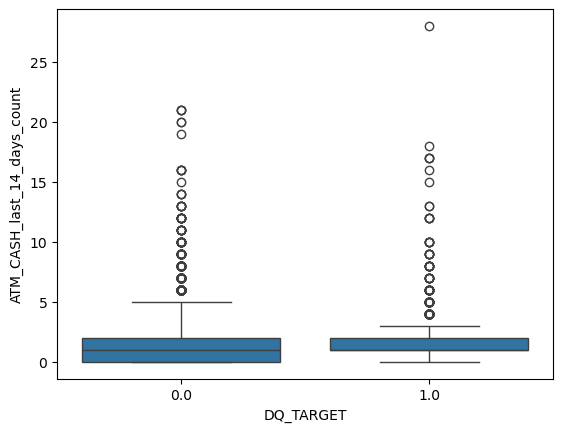

In [83]:
sns.boxplot(final_features_df, x='DQ_TARGET', y='ATM_CASH_last_14_days_count')

In [84]:
final_features_dq_0 = final_features_df[final_features_df['DQ_TARGET'] == 0]
final_features_dq_1 = final_features_df[final_features_df['DQ_TARGET'] == 1]

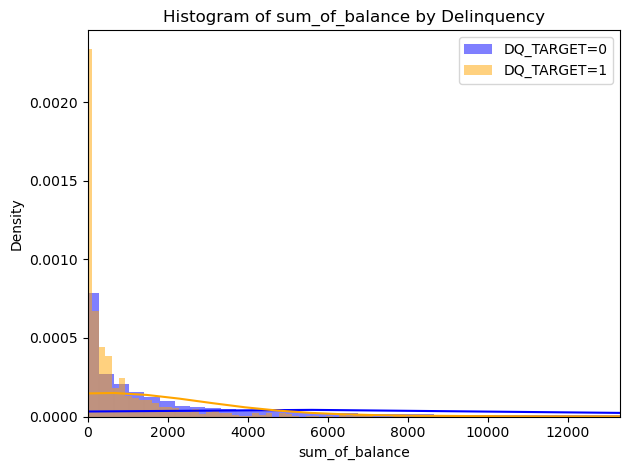

In [85]:
feature = 'sum_of_balance'# sum_of_balance SELF_TRANSFER_last_year_median
x_min, x_max = np.percentile(final_features_df[feature], [10,90])
if 'count' in feature:
    sns.boxplot(final_features_df, x='DQ_TARGET', y=feature)
    plt.title(f"Box Plot of {feature} by Delinquency")
else:
    sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, color='blue', alpha=0.5)
    sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, color='orange', alpha=0.5)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.title(f"Histogram of {feature} by Delinquency")
plt.tight_layout()
plt.show()

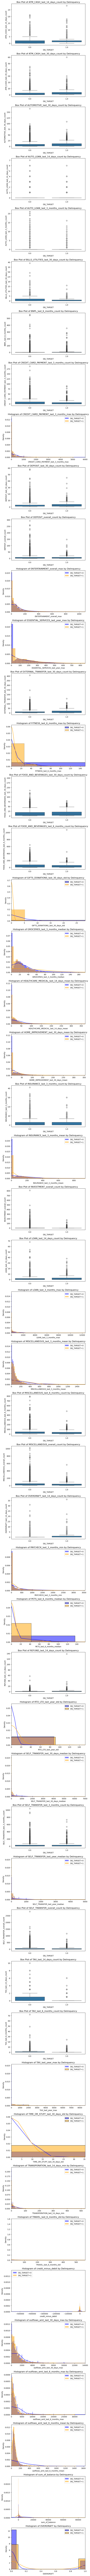

In [88]:
top_features_subset = top_50_features_l1
fig, axes = plt.subplots(len(top_features_subset), 1, figsize=(7, len(top_features_subset) * 4))

for i, feature in enumerate(top_features_subset):
    x_min, x_max = np.percentile(final_features_df[feature], [0,99])
    if 'count' in feature:
        sns.boxplot(final_features_df, x='DQ_TARGET', y=feature, ax=axes[i])
        axes[i].set_title(f"Box Plot of {feature} by Delinquency")
    else:
        sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, ax=axes[i], color='blue', alpha=0.5)
        sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, ax=axes[i], color='orange', alpha=0.5)
        axes[i].legend()
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f"Histogram of {feature} by Delinquency")

plt.tight_layout()
plt.show()

In [ ]:
top_features_subset = top_50_features_pb
fig, axes = plt.subplots(len(top_features_subset), 1, figsize=(7, len(top_features_subset) * 4))

for i, feature in enumerate(top_features_subset):
    x_min, x_max = np.percentile(final_features_df[feature], [0,99])
    if 'count' in feature:
        sns.boxplot(final_features_df, x='DQ_TARGET', y=feature, ax=axes[i])
        axes[i].set_title(f"Box Plot of {feature} by Delinquency")
    else:
        sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, ax=axes[i], color='blue', alpha=0.5)
        sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, ax=axes[i], color='orange', alpha=0.5)
        axes[i].legend()
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f"Histogram of {feature} by Delinquency")

plt.tight_layout()
plt.show()

#### Multiple Model Training

In [89]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier # pip install
from lightgbm import LGBMClassifier # pip install
from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    """Trains and evaluates the specified model."""
    models = {
        "HistGB": HistGradientBoostingClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0),
        "LightGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1)
    }
    
    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(models.keys())}")
    
    model = models[model_type]

    # Train model and track training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    print(f"Training Time: {end - start:.4f} seconds")

    # Predict model and track inference time
    start_pred = time.time()
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    end_pred = time.time()

    print(f"Prediction Time: {end_pred - start_pred:.4f} seconds")


    # Evaluation Metrics
    metrics = {
        "ROC_AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Print Metrics
    print(f'{model_type} metrics:')
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_type})")
    plt.show()

    return model, metrics

Training Time: 6.6306 seconds
Prediction Time: 0.0322 seconds
HistGB metrics:
	ROC_AUC: 0.7712464030039303
	Accuracy: 0.9129166666666667
	Precision: 0.47058823529411764
	Recall: 0.038461538461538464
	F1-Score: 0.07111111111111111
	Confusion Matrix: [[2183    9]
 [ 200    8]]


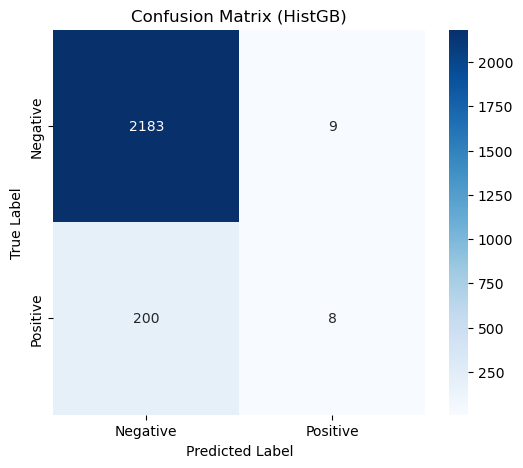

Training Time: 56.5833 seconds
Prediction Time: 0.1117 seconds
CatBoost metrics:
	ROC_AUC: 0.7785314166900618
	Accuracy: 0.9133333333333333
	Precision: 0.5
	Recall: 0.02403846153846154
	F1-Score: 0.045871559633027525
	Confusion Matrix: [[2187    5]
 [ 203    5]]


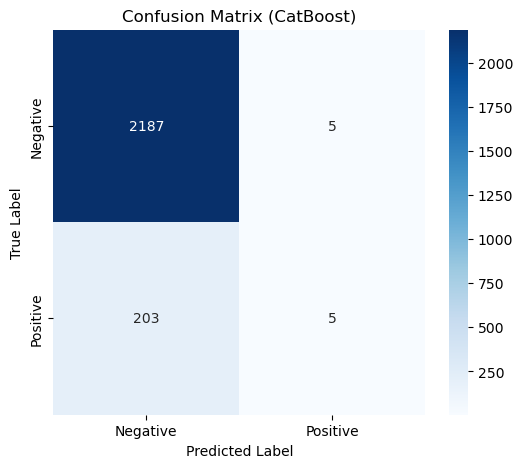

[LightGBM] [Info] Number of positive: 798, number of negative: 8802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347217
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 1773
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083125 -> initscore=-2.400626
[LightGBM] [Info] Start training from score -2.400626
Training Time: 4.8098 seconds
Prediction Time: 0.0570 seconds
LightGBM metrics:
	ROC_AUC: 0.759839100224593
	Accuracy: 0.91375
	Precision: 0.5384615384615384
	Recall: 0.03365384615384615
	F1-Score: 0.06334841628959276
	Confusion Matrix: [[2186    6]
 [ 201    7]]


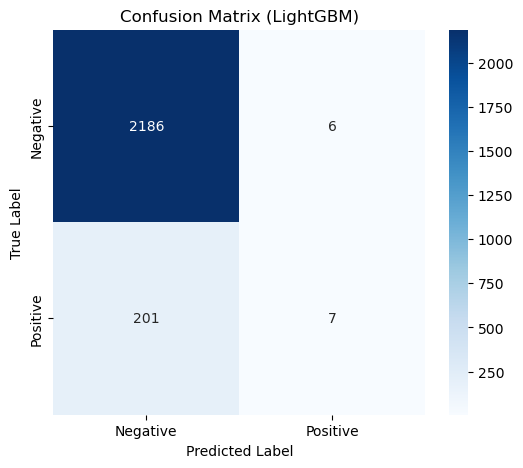

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:52:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 8.5356 seconds
Prediction Time: 0.4943 seconds
XGBoost metrics:
	ROC_AUC: 0.750609734699607
	Accuracy: 0.9104166666666667
	Precision: 0.3333333333333333
	Recall: 0.03365384615384615
	F1-Score: 0.0611353711790393
	Confusion Matrix: [[2178   14]
 [ 201    7]]


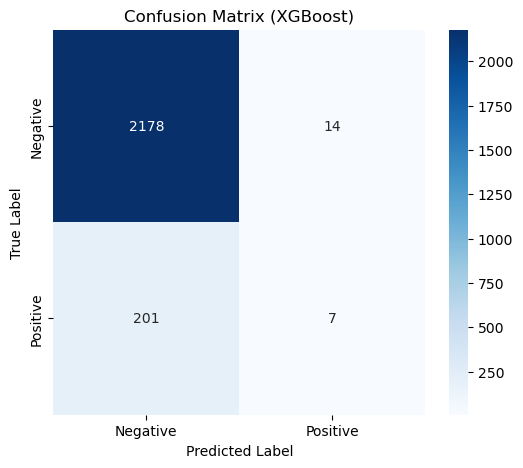

Training Time: 6.7381 seconds
Prediction Time: 0.3521 seconds
LogisticRegression metrics:
	ROC_AUC: 0.6726514247613701
	Accuracy: 0.8895833333333333
	Precision: 0.12
	Recall: 0.04326923076923077
	F1-Score: 0.0636042402826855
	Confusion Matrix: [[2126   66]
 [ 199    9]]


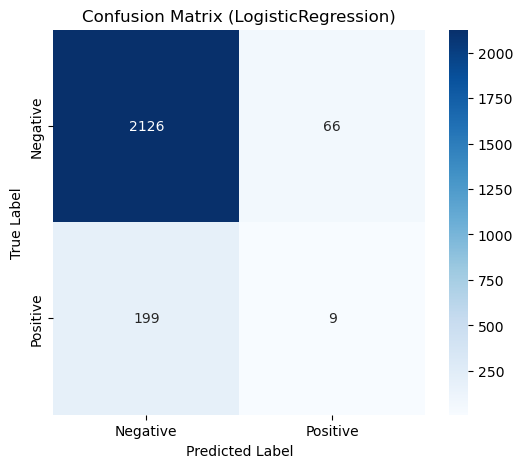

In [91]:
# testing models with all standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

Training Time: 0.4139 seconds
Prediction Time: 0.0114 seconds
HistGB metrics:
	ROC_AUC: 0.7466508457327343
	Accuracy: 0.9133333333333333
	Precision: 0.5
	Recall: 0.057692307692307696
	F1-Score: 0.10344827586206896
	Confusion Matrix: [[2180   12]
 [ 196   12]]


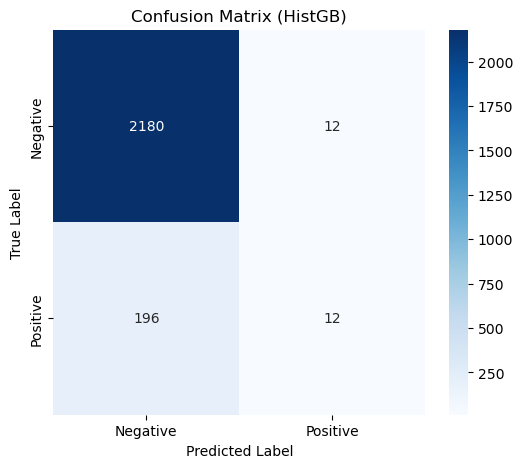

Training Time: 3.7993 seconds
Prediction Time: 0.0074 seconds
CatBoost metrics:
	ROC_AUC: 0.7719559324115666
	Accuracy: 0.9145833333333333
	Precision: 0.6363636363636364
	Recall: 0.03365384615384615
	F1-Score: 0.0639269406392694
	Confusion Matrix: [[2188    4]
 [ 201    7]]


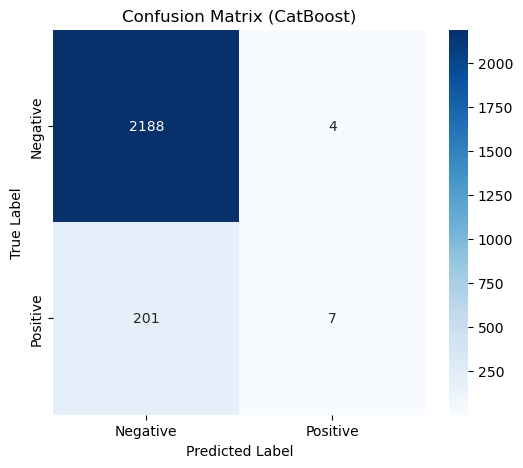

[LightGBM] [Info] Number of positive: 798, number of negative: 8802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8068
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083125 -> initscore=-2.400626
[LightGBM] [Info] Start training from score -2.400626
Training Time: 0.2073 seconds
Prediction Time: 0.0067 seconds
LightGBM metrics:
	ROC_AUC: 0.7602064763475576
	Accuracy: 0.91375
	Precision: 0.5263157894736842
	Recall: 0.04807692307692308
	F1-Score: 0.0881057268722467
	Confusion Matrix: [[2183    9]
 [ 198   10]]


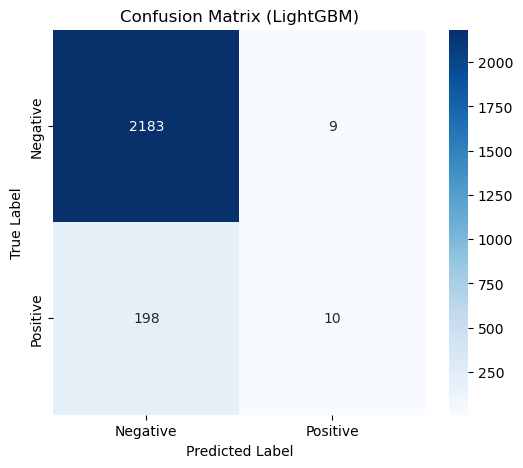

/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:52:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.3342 seconds
Prediction Time: 0.0168 seconds
XGBoost metrics:
	ROC_AUC: 0.7444027231892195
	Accuracy: 0.9104166666666667
	Precision: 0.3793103448275862
	Recall: 0.052884615384615384
	F1-Score: 0.09282700421940929
	Confusion Matrix: [[2174   18]
 [ 197   11]]


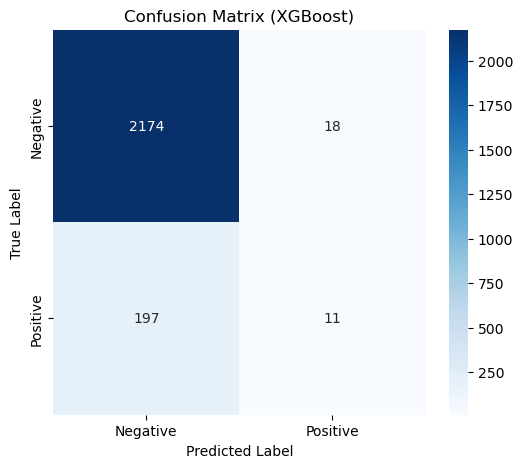

Training Time: 0.4672 seconds
Prediction Time: 0.0041 seconds
LogisticRegression metrics:
	ROC_AUC: 0.7123828782987086
	Accuracy: 0.91125
	Precision: 0.2727272727272727
	Recall: 0.014423076923076924
	F1-Score: 0.0273972602739726
	Confusion Matrix: [[2184    8]
 [ 205    3]]


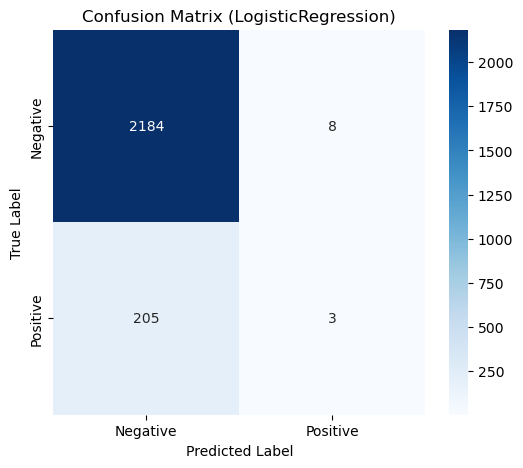

In [92]:
# testing models with l1 top 50 standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_standardized_top_50_l1, y_train, X_test_standardized_top_50_l1, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [ ]:
# gambling not in my top features, should inspect that

## Week 6

#### SMOTE

In [ ]:
# !pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
# Check class counts
count_0, count_1 = y_train.value_counts()[0], y_train.value_counts()[1]
new_0 = int(0.8 * count_0)  # Target count for balancing
new_1 = int(2.5* count_1)

# Ensure SMOTE does not create more than the original number of samples
smote = SMOTE(sampling_strategy={1: new_1},)

# Undersampling the majority class to match the new minority class count
under = RandomUnderSampler(sampling_strategy={0: new_0},)

# Combine SMOTE & Undersampling in a pipeline
resample_pipeline = Pipeline(steps=[('smote', smote), ('under', under)])

# Apply resampling
X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train_standardized_top_50_l1, y_train)

In [ ]:
# testing models with SMOTE l1 top 50 standardized features 
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_test_standardized_top_50_l1, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [ ]:
# Check class counts
count_0, count_1 = y_train.value_counts()[0], y_train.value_counts()[1]
new_0 = int(0.8 * count_0)  # Target count for balancing
new_1 = int(2.5* count_1)

# Ensure SMOTE does not create more than the original number of samples
smote = SMOTE(sampling_strategy={1: new_1},)

# Undersampling the majority class to match the new minority class count
under = RandomUnderSampler(sampling_strategy={0: new_0},)

# Combine SMOTE & Undersampling in a pipeline
resample_pipeline = Pipeline(steps=[('smote', smote), ('under', under)])

# Apply resampling
X_train_resampled, y_train_resampled = resample_pipeline.fit_resample(X_train_standardized, y_train)

In [ ]:
# testing models with SMOTE all standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_test_standardized, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

## Week 7

#### Hyperparameter Tuning and Other Model Testing

In [105]:
# !pip install optuna

In [152]:
import optuna
import logging
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [142]:
logging.basicConfig(filename="optuna_trials.log", level=logging.INFO, format="%(asctime)s - %(message)s")

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    final_features_df.drop(columns='DQ_TARGET'), final_features_df['DQ_TARGET'], test_size=0.3
)

In [127]:
# X_val, X_test, y_val, y_test = train_test_split(
#     X_test, y_test, test_size=0.5
# )

In [128]:
X_train_standardized, X_test_standardized = standardize(X_train, X_test)
_, X_val_standardized = standardize(X_train, X_val)

In [147]:
def objective(trial, X, y):
    model_name = trial.suggest_categorical("model", ["HistGB", "LightGBM", "XGBoost", "LogisticRegression"]) # removed CatBoost because it takes long
    print(f"Trial {trial.number}: model {model_name}")
    logging.info(f"Trial {trial.number}: model {model_name}")
    
    if model_name == "HistGB":
        model = HistGradientBoostingClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            max_iter=trial.suggest_int("max_iter", 50, 300),
            max_depth=trial.suggest_int("max_depth", 3, 12)
        )
    elif model_name == "CatBoost":
        model = CatBoostClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            depth=trial.suggest_int("depth", 3, 12),
            iterations=trial.suggest_int("iterations", 50, 300),
            verbose=0
        )
    elif model_name == "LightGBM":
        model = LGBMClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            n_estimators=trial.suggest_int("n_estimators", 50, 300),
            num_leaves=trial.suggest_int("num_leaves", 20, 150),
            verbose=-1
        )
    elif model_name == "XGBoost":
        model = XGBClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            n_estimators=trial.suggest_int("n_estimators", 50, 300),
            max_depth=trial.suggest_int("max_depth", 3, 12),
            # use_label_encoder=False,
            eval_metric='logloss'
        )
    else:
        model = LogisticRegression(
            C=trial.suggest_float("C", 0.01, 10, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 500)
        )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='roc_auc'))
    
    print(f"Trial {trial.number} - Model: {model_name}, Score: {score:.4f}")
    logging.info(f"Trial {trial.number} - Model: {model_name}, Score: {score:.4f}")
    
    return score

In [148]:
def run_optimization(X, y, n_trials=50):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    print("Best parameters:", study.best_params)
    return study

In [146]:
# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best parameters:", study.best_params)

[I 2025-02-16 08:57:16,580] A new study created in memory with name: no-name-717110d3-8c22-40a0-8072-ad5c3d148af3


Trial 0: model LightGBM


[I 2025-02-16 08:57:47,493] Trial 0 finished with value: 0.7508597494101736 and parameters: {'model': 'LightGBM', 'lr': 0.04983097083020548, 'n_estimators': 97, 'num_leaves': 139}. Best is trial 0 with value: 0.7508597494101736.


Trial 0 - Model: LightGBM, Score: 0.7509
Trial 1: model HistGB


[I 2025-02-16 08:58:00,948] Trial 1 finished with value: 0.7412377675140726 and parameters: {'model': 'HistGB', 'lr': 0.16770923903720422, 'max_iter': 81, 'max_depth': 8}. Best is trial 0 with value: 0.7508597494101736.


Trial 1 - Model: HistGB, Score: 0.7412
Trial 2: model HistGB


[I 2025-02-16 08:58:30,326] Trial 2 finished with value: 0.7548686489967906 and parameters: {'model': 'HistGB', 'lr': 0.01281786216325563, 'max_iter': 207, 'max_depth': 9}. Best is trial 2 with value: 0.7548686489967906.


Trial 2 - Model: HistGB, Score: 0.7549
Trial 3: model LightGBM


[I 2025-02-16 08:58:51,219] Trial 3 finished with value: 0.7450426312254491 and parameters: {'model': 'LightGBM', 'lr': 0.014884059789843735, 'n_estimators': 142, 'num_leaves': 44}. Best is trial 2 with value: 0.7548686489967906.


Trial 3 - Model: LightGBM, Score: 0.7450
Trial 4: model HistGB


[I 2025-02-16 08:58:56,102] Trial 4 finished with value: 0.7544768798381591 and parameters: {'model': 'HistGB', 'lr': 0.09791909027202668, 'max_iter': 56, 'max_depth': 3}. Best is trial 2 with value: 0.7548686489967906.


Trial 4 - Model: HistGB, Score: 0.7545
Trial 5: model HistGB


[I 2025-02-16 08:59:27,366] Trial 5 finished with value: 0.7484233845295559 and parameters: {'model': 'HistGB', 'lr': 0.06316364981766946, 'max_iter': 215, 'max_depth': 11}. Best is trial 2 with value: 0.7548686489967906.


Trial 5 - Model: HistGB, Score: 0.7484
Trial 6: model LogisticRegression


[I 2025-02-16 08:59:46,644] Trial 6 finished with value: 0.6634445792240328 and parameters: {'model': 'LogisticRegression', 'C': 0.11513548623375813, 'max_iter': 129}. Best is trial 2 with value: 0.7548686489967906.


Trial 6 - Model: LogisticRegression, Score: 0.6634
Trial 7: model HistGB


[I 2025-02-16 09:00:00,000] Trial 7 finished with value: 0.7455871799358148 and parameters: {'model': 'HistGB', 'lr': 0.10089151834118797, 'max_iter': 77, 'max_depth': 11}. Best is trial 2 with value: 0.7548686489967906.


Trial 7 - Model: HistGB, Score: 0.7456
Trial 8: model LogisticRegression


[I 2025-02-16 09:00:11,743] Trial 8 finished with value: 0.6739239394280588 and parameters: {'model': 'LogisticRegression', 'C': 0.024226969889461637, 'max_iter': 389}. Best is trial 2 with value: 0.7548686489967906.


Trial 8 - Model: LogisticRegression, Score: 0.6739
Trial 9: model LogisticRegression


[I 2025-02-16 09:00:33,441] Trial 9 finished with value: 0.6594195238883955 and parameters: {'model': 'LogisticRegression', 'C': 0.24817594029202178, 'max_iter': 306}. Best is trial 2 with value: 0.7548686489967906.


Trial 9 - Model: LogisticRegression, Score: 0.6594
Trial 10: model XGBoost


[I 2025-02-16 09:01:59,055] Trial 10 finished with value: 0.7534718946639689 and parameters: {'model': 'XGBoost', 'lr': 0.010109254784075738, 'n_estimators': 291, 'max_depth': 7}. Best is trial 2 with value: 0.7548686489967906.


Trial 10 - Model: XGBoost, Score: 0.7535
Trial 11: model HistGB


[I 2025-02-16 09:02:07,892] Trial 11 finished with value: 0.7582349068333568 and parameters: {'model': 'HistGB', 'lr': 0.02351612892391445, 'max_iter': 193, 'max_depth': 3}. Best is trial 11 with value: 0.7582349068333568.


Trial 11 - Model: HistGB, Score: 0.7582
Trial 12: model HistGB


[I 2025-02-16 09:02:16,818] Trial 12 finished with value: 0.7575955482419333 and parameters: {'model': 'HistGB', 'lr': 0.022391259727176337, 'max_iter': 195, 'max_depth': 3}. Best is trial 11 with value: 0.7582349068333568.


Trial 12 - Model: HistGB, Score: 0.7576
Trial 13: model XGBoost


[I 2025-02-16 09:02:43,390] Trial 13 finished with value: 0.7616819260963682 and parameters: {'model': 'XGBoost', 'lr': 0.025647465043401634, 'n_estimators': 271, 'max_depth': 3}. Best is trial 13 with value: 0.7616819260963682.


Trial 13 - Model: XGBoost, Score: 0.7617
Trial 14: model XGBoost


[I 2025-02-16 09:03:29,302] Trial 14 finished with value: 0.7612141772033372 and parameters: {'model': 'XGBoost', 'lr': 0.026004675482609128, 'n_estimators': 278, 'max_depth': 5}. Best is trial 13 with value: 0.7616819260963682.


Trial 14 - Model: XGBoost, Score: 0.7612
Trial 15: model XGBoost


[I 2025-02-16 09:04:14,638] Trial 15 finished with value: 0.7607368209630753 and parameters: {'model': 'XGBoost', 'lr': 0.026319304738522637, 'n_estimators': 276, 'max_depth': 5}. Best is trial 13 with value: 0.7616819260963682.


Trial 15 - Model: XGBoost, Score: 0.7607
Trial 16: model XGBoost


[I 2025-02-16 09:04:53,740] Trial 16 finished with value: 0.7619366162299741 and parameters: {'model': 'XGBoost', 'lr': 0.03373476093833653, 'n_estimators': 228, 'max_depth': 5}. Best is trial 16 with value: 0.7619366162299741.


Trial 16 - Model: XGBoost, Score: 0.7619
Trial 17: model XGBoost


[I 2025-02-16 09:05:30,158] Trial 17 finished with value: 0.7602990156631555 and parameters: {'model': 'XGBoost', 'lr': 0.037206279518448265, 'n_estimators': 217, 'max_depth': 5}. Best is trial 16 with value: 0.7619366162299741.


Trial 17 - Model: XGBoost, Score: 0.7603
Trial 18: model XGBoost


[I 2025-02-16 09:06:15,864] Trial 18 finished with value: 0.7603491402137371 and parameters: {'model': 'XGBoost', 'lr': 0.03777901059900651, 'n_estimators': 208, 'max_depth': 6}. Best is trial 16 with value: 0.7619366162299741.


Trial 18 - Model: XGBoost, Score: 0.7603
Trial 19: model XGBoost


[I 2025-02-16 09:06:47,637] Trial 19 finished with value: 0.7610656803794268 and parameters: {'model': 'XGBoost', 'lr': 0.017706194699178477, 'n_estimators': 223, 'max_depth': 4}. Best is trial 16 with value: 0.7619366162299741.


Trial 19 - Model: XGBoost, Score: 0.7611
Trial 20: model XGBoost


[I 2025-02-16 09:07:37,321] Trial 20 finished with value: 0.7572880142189695 and parameters: {'model': 'XGBoost', 'lr': 0.0554470528388637, 'n_estimators': 242, 'max_depth': 6}. Best is trial 16 with value: 0.7619366162299741.


Trial 20 - Model: XGBoost, Score: 0.7573
Trial 21: model XGBoost


[I 2025-02-16 09:08:26,519] Trial 21 finished with value: 0.7596835749966973 and parameters: {'model': 'XGBoost', 'lr': 0.029423038786068584, 'n_estimators': 300, 'max_depth': 5}. Best is trial 16 with value: 0.7619366162299741.


Trial 21 - Model: XGBoost, Score: 0.7597
Trial 22: model XGBoost


[I 2025-02-16 09:08:59,104] Trial 22 finished with value: 0.7642041679061817 and parameters: {'model': 'XGBoost', 'lr': 0.032465490200885856, 'n_estimators': 249, 'max_depth': 4}. Best is trial 22 with value: 0.7642041679061817.


Trial 22 - Model: XGBoost, Score: 0.7642
Trial 23: model XGBoost


[I 2025-02-16 09:09:23,484] Trial 23 finished with value: 0.763594073558433 and parameters: {'model': 'XGBoost', 'lr': 0.03662925483007413, 'n_estimators': 167, 'max_depth': 4}. Best is trial 22 with value: 0.7642041679061817.


Trial 23 - Model: XGBoost, Score: 0.7636
Trial 24: model XGBoost


[I 2025-02-16 09:09:45,938] Trial 24 finished with value: 0.7608591624980816 and parameters: {'model': 'XGBoost', 'lr': 0.07453908768860551, 'n_estimators': 166, 'max_depth': 4}. Best is trial 22 with value: 0.7642041679061817.


Trial 24 - Model: XGBoost, Score: 0.7609
Trial 25: model XGBoost


[I 2025-02-16 09:10:08,741] Trial 25 finished with value: 0.7642097767193806 and parameters: {'model': 'XGBoost', 'lr': 0.041860800774292085, 'n_estimators': 166, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 25 - Model: XGBoost, Score: 0.7642
Trial 26: model LightGBM


[I 2025-02-16 09:10:51,281] Trial 26 finished with value: 0.7567428360684046 and parameters: {'model': 'LightGBM', 'lr': 0.043827954742639647, 'n_estimators': 131, 'num_leaves': 150}. Best is trial 25 with value: 0.7642097767193806.


Trial 26 - Model: LightGBM, Score: 0.7567
Trial 27: model XGBoost


[I 2025-02-16 09:11:14,193] Trial 27 finished with value: 0.7588393927533064 and parameters: {'model': 'XGBoost', 'lr': 0.07563680690166613, 'n_estimators': 176, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 27 - Model: XGBoost, Score: 0.7588
Trial 28: model XGBoost


[I 2025-02-16 09:11:37,525] Trial 28 finished with value: 0.7287497879796767 and parameters: {'model': 'XGBoost', 'lr': 0.01716886730330209, 'n_estimators': 67, 'max_depth': 7}. Best is trial 25 with value: 0.7642097767193806.


Trial 28 - Model: XGBoost, Score: 0.7287
Trial 29: model LightGBM


[I 2025-02-16 09:11:54,772] Trial 29 finished with value: 0.7560265716808593 and parameters: {'model': 'LightGBM', 'lr': 0.04332622174426194, 'n_estimators': 181, 'num_leaves': 23}. Best is trial 25 with value: 0.7642097767193806.


Trial 29 - Model: LightGBM, Score: 0.7560
Trial 30: model XGBoost


[I 2025-02-16 09:12:48,578] Trial 30 finished with value: 0.7551618196418186 and parameters: {'model': 'XGBoost', 'lr': 0.03441512502474677, 'n_estimators': 135, 'max_depth': 9}. Best is trial 25 with value: 0.7642097767193806.


Trial 30 - Model: XGBoost, Score: 0.7552
Trial 31: model XGBoost


[I 2025-02-16 09:13:20,884] Trial 31 finished with value: 0.7637663898592467 and parameters: {'model': 'XGBoost', 'lr': 0.03355337772247933, 'n_estimators': 246, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 31 - Model: XGBoost, Score: 0.7638
Trial 32: model XGBoost


[I 2025-02-16 09:13:54,154] Trial 32 finished with value: 0.7637905992234212 and parameters: {'model': 'XGBoost', 'lr': 0.02080095339342872, 'n_estimators': 248, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 32 - Model: XGBoost, Score: 0.7638
Trial 33: model XGBoost


[I 2025-02-16 09:14:49,178] Trial 33 finished with value: 0.759173199907157 and parameters: {'model': 'XGBoost', 'lr': 0.019799361282868938, 'n_estimators': 244, 'max_depth': 6}. Best is trial 25 with value: 0.7642097767193806.


Trial 33 - Model: XGBoost, Score: 0.7592
Trial 34: model LightGBM


[I 2025-02-16 09:15:50,499] Trial 34 finished with value: 0.760688270822845 and parameters: {'model': 'LightGBM', 'lr': 0.056938711853301106, 'n_estimators': 254, 'num_leaves': 104}. Best is trial 25 with value: 0.7642097767193806.


Trial 34 - Model: LightGBM, Score: 0.7607
Trial 35: model XGBoost


[I 2025-02-16 09:16:17,311] Trial 35 finished with value: 0.7634154432053969 and parameters: {'model': 'XGBoost', 'lr': 0.04695822594105416, 'n_estimators': 194, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 35 - Model: XGBoost, Score: 0.7634
Trial 36: model LogisticRegression


[I 2025-02-16 09:17:10,739] Trial 36 finished with value: 0.6486002452204257 and parameters: {'model': 'LogisticRegression', 'C': 5.142942081108449, 'max_iter': 489}. Best is trial 25 with value: 0.7642097767193806.


Trial 36 - Model: LogisticRegression, Score: 0.6486
Trial 37: model XGBoost


[I 2025-02-16 09:17:37,211] Trial 37 finished with value: 0.7617508772529836 and parameters: {'model': 'XGBoost', 'lr': 0.029544616262313143, 'n_estimators': 263, 'max_depth': 3}. Best is trial 25 with value: 0.7642097767193806.


Trial 37 - Model: XGBoost, Score: 0.7618
Trial 38: model LightGBM


[I 2025-02-16 09:18:18,369] Trial 38 finished with value: 0.7474365400802828 and parameters: {'model': 'LightGBM', 'lr': 0.01322134873161582, 'n_estimators': 197, 'num_leaves': 74}. Best is trial 25 with value: 0.7642097767193806.


Trial 38 - Model: LightGBM, Score: 0.7474
Trial 39: model XGBoost


[I 2025-02-16 09:18:51,449] Trial 39 finished with value: 0.7635595099072149 and parameters: {'model': 'XGBoost', 'lr': 0.01930048418145972, 'n_estimators': 242, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 39 - Model: XGBoost, Score: 0.7636
Trial 40: model LogisticRegression


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2025-02-16 09:19:45,347] Trial 40 finished with value: 0.6474736087248161 and parameters: {'model': 'LogisticRegression', 'C': 8.383848815406115, 'max_iter': 483}. Best is trial 25 with value: 0.7642097767193806.


Trial 40 - Model: LogisticRegression, Score: 0.6475
Trial 41: model XGBoost


[I 2025-02-16 09:20:10,895] Trial 41 finished with value: 0.7610373922138193 and parameters: {'model': 'XGBoost', 'lr': 0.031720456075083565, 'n_estimators': 162, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 41 - Model: XGBoost, Score: 0.7610
Trial 42: model XGBoost


[I 2025-02-16 09:20:31,376] Trial 42 finished with value: 0.7388062760136357 and parameters: {'model': 'XGBoost', 'lr': 0.18975377277067548, 'n_estimators': 147, 'max_depth': 4}. Best is trial 25 with value: 0.7642097767193806.


Trial 42 - Model: XGBoost, Score: 0.7388
Trial 43: model XGBoost


[I 2025-02-16 09:21:05,308] Trial 43 finished with value: 0.760581840737062 and parameters: {'model': 'XGBoost', 'lr': 0.03983097091995857, 'n_estimators': 196, 'max_depth': 5}. Best is trial 25 with value: 0.7642097767193806.


Trial 43 - Model: XGBoost, Score: 0.7606
Trial 44: model XGBoost


[I 2025-02-16 09:21:17,289] Trial 44 finished with value: 0.7604183311014813 and parameters: {'model': 'XGBoost', 'lr': 0.05013067517198393, 'n_estimators': 103, 'max_depth': 3}. Best is trial 25 with value: 0.7642097767193806.


Trial 44 - Model: XGBoost, Score: 0.7604
Trial 45: model HistGB


[I 2025-02-16 09:21:39,652] Trial 45 finished with value: 0.748726014707068 and parameters: {'model': 'HistGB', 'lr': 0.0696088545710429, 'max_iter': 152, 'max_depth': 9}. Best is trial 25 with value: 0.7642097767193806.


Trial 45 - Model: HistGB, Score: 0.7487
Trial 46: model XGBoost


[I 2025-02-16 09:22:27,552] Trial 46 finished with value: 0.7576173106549889 and parameters: {'model': 'XGBoost', 'lr': 0.09152348209817707, 'n_estimators': 113, 'max_depth': 12}. Best is trial 25 with value: 0.7642097767193806.


Trial 46 - Model: XGBoost, Score: 0.7576
Trial 47: model LogisticRegression


[I 2025-02-16 09:22:35,052] Trial 47 finished with value: 0.6782322142505119 and parameters: {'model': 'LogisticRegression', 'C': 0.01087318728645209, 'max_iter': 306}. Best is trial 25 with value: 0.7642097767193806.


Trial 47 - Model: LogisticRegression, Score: 0.6782
Trial 48: model XGBoost


[I 2025-02-16 09:23:10,996] Trial 48 finished with value: 0.7574562364927306 and parameters: {'model': 'XGBoost', 'lr': 0.021707097258431476, 'n_estimators': 153, 'max_depth': 6}. Best is trial 25 with value: 0.7642097767193806.


Trial 48 - Model: XGBoost, Score: 0.7575
Trial 49: model HistGB


[I 2025-02-16 09:23:27,459] Trial 49 finished with value: 0.7499377988091219 and parameters: {'model': 'HistGB', 'lr': 0.11863589639747633, 'max_iter': 114, 'max_depth': 8}. Best is trial 25 with value: 0.7642097767193806.


Trial 49 - Model: HistGB, Score: 0.7499
Best parameters: {'model': 'XGBoost', 'lr': 0.041860800774292085, 'n_estimators': 166, 'max_depth': 4}


**For entire `final_features_df`**:

Best parameters: {'model': 'XGBoost', 'lr': 0.041860800774292085, 'n_estimators': 166, 'max_depth': 4} -- 0.7642097767193806

**For top 50 features**:

Best parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9} -- 0.7701703831605068

**For top 100 features**:

Best parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110} -- 0.7697076110002644

In [159]:
X_train_standardized_l1_50, X_test_standardized_l1_50 = get_lasso_features(X_train_standardized, y_train, X_test_standardized)
X_train_standardized_l1_100, X_test_standardized_l1_100 = get_lasso_features(X_train_standardized, y_train, X_test_standardized, max_features=100)

In [156]:
run_optimization(X_train_standardized_l1_50, y_train)

[I 2025-02-16 09:25:43,668] A new study created in memory with name: no-name-1c77e256-6007-45d8-a8ab-f0d93425930e
[I 2025-02-16 09:25:43,778] Trial 0 finished with value: 0.7531442758468295 and parameters: {'model': 'LogisticRegression', 'C': 1.0472664916198309, 'max_iter': 284}. Best is trial 0 with value: 0.7531442758468295.
[I 2025-02-16 09:25:43,856] Trial 1 finished with value: 0.7458249201748403 and parameters: {'model': 'LogisticRegression', 'C': 0.06709733013676819, 'max_iter': 122}. Best is trial 0 with value: 0.7531442758468295.


Trial 0: model LogisticRegression
Trial 0 - Model: LogisticRegression, Score: 0.7531
Trial 1: model LogisticRegression
Trial 1 - Model: LogisticRegression, Score: 0.7458
Trial 2: model HistGB


[I 2025-02-16 09:25:46,347] Trial 2 finished with value: 0.7539314793758836 and parameters: {'model': 'HistGB', 'lr': 0.08816728583868495, 'max_iter': 107, 'max_depth': 11}. Best is trial 2 with value: 0.7539314793758836.


Trial 2 - Model: HistGB, Score: 0.7539
Trial 3: model HistGB


[I 2025-02-16 09:25:47,315] Trial 3 finished with value: 0.7336515763162376 and parameters: {'model': 'HistGB', 'lr': 0.012361297076622235, 'max_iter': 132, 'max_depth': 3}. Best is trial 2 with value: 0.7539314793758836.
[I 2025-02-16 09:25:47,385] Trial 4 finished with value: 0.7460898613682293 and parameters: {'model': 'LogisticRegression', 'C': 0.038735012861097595, 'max_iter': 465}. Best is trial 2 with value: 0.7539314793758836.


Trial 3 - Model: HistGB, Score: 0.7337
Trial 4: model LogisticRegression
Trial 4 - Model: LogisticRegression, Score: 0.7461
Trial 5: model HistGB


[I 2025-02-16 09:25:50,056] Trial 5 finished with value: 0.761660934200464 and parameters: {'model': 'HistGB', 'lr': 0.042227320896738446, 'max_iter': 112, 'max_depth': 12}. Best is trial 5 with value: 0.761660934200464.


Trial 5 - Model: HistGB, Score: 0.7617
Trial 6: model HistGB


[I 2025-02-16 09:25:53,750] Trial 6 finished with value: 0.7599202542078911 and parameters: {'model': 'HistGB', 'lr': 0.043679142168376706, 'max_iter': 296, 'max_depth': 5}. Best is trial 5 with value: 0.761660934200464.
[I 2025-02-16 09:25:53,865] Trial 7 finished with value: 0.7506398060423776 and parameters: {'model': 'LogisticRegression', 'C': 3.2554075797937676, 'max_iter': 498}. Best is trial 5 with value: 0.761660934200464.


Trial 6 - Model: HistGB, Score: 0.7599
Trial 7: model LogisticRegression
Trial 7 - Model: LogisticRegression, Score: 0.7506
Trial 8: model HistGB


[I 2025-02-16 09:25:59,953] Trial 8 finished with value: 0.7701703831605068 and parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:26:00,023] Trial 9 finished with value: 0.7440762042745592 and parameters: {'model': 'LogisticRegression', 'C': 0.028216778398336088, 'max_iter': 150}. Best is trial 8 with value: 0.7701703831605068.


Trial 8 - Model: HistGB, Score: 0.7702
Trial 9: model LogisticRegression
Trial 9 - Model: LogisticRegression, Score: 0.7441
Trial 10: model XGBoost


[I 2025-02-16 09:26:01,900] Trial 10 finished with value: 0.7422492186730005 and parameters: {'model': 'XGBoost', 'lr': 0.01457221071452907, 'n_estimators': 75, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 10 - Model: XGBoost, Score: 0.7422
Trial 11: model LightGBM


[I 2025-02-16 09:26:17,483] Trial 11 finished with value: 0.7562932900331849 and parameters: {'model': 'LightGBM', 'lr': 0.034992485562280295, 'n_estimators': 297, 'num_leaves': 149}. Best is trial 8 with value: 0.7701703831605068.


Trial 11 - Model: LightGBM, Score: 0.7563
Trial 12: model HistGB


[I 2025-02-16 09:26:19,334] Trial 12 finished with value: 0.7469720343975386 and parameters: {'model': 'HistGB', 'lr': 0.026668619677705365, 'max_iter': 67, 'max_depth': 12}. Best is trial 8 with value: 0.7701703831605068.


Trial 12 - Model: HistGB, Score: 0.7470
Trial 13: model HistGB


[I 2025-02-16 09:26:24,494] Trial 13 finished with value: 0.7485454797093171 and parameters: {'model': 'HistGB', 'lr': 0.09957022513037178, 'max_iter': 223, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 13 - Model: HistGB, Score: 0.7485
Trial 14: model LightGBM


[I 2025-02-16 09:26:26,978] Trial 14 finished with value: 0.762647418324113 and parameters: {'model': 'LightGBM', 'lr': 0.024064962487835583, 'n_estimators': 225, 'num_leaves': 22}. Best is trial 8 with value: 0.7701703831605068.


Trial 14 - Model: LightGBM, Score: 0.7626
Trial 15: model LightGBM


[I 2025-02-16 09:26:30,129] Trial 15 finished with value: 0.7616339924993543 and parameters: {'model': 'LightGBM', 'lr': 0.020267269173556337, 'n_estimators': 231, 'num_leaves': 29}. Best is trial 8 with value: 0.7701703831605068.


Trial 15 - Model: LightGBM, Score: 0.7616
Trial 16: model LightGBM


[I 2025-02-16 09:26:32,032] Trial 16 finished with value: 0.7577548066420576 and parameters: {'model': 'LightGBM', 'lr': 0.02023932166730442, 'n_estimators': 161, 'num_leaves': 25}. Best is trial 8 with value: 0.7701703831605068.


Trial 16 - Model: LightGBM, Score: 0.7578
Trial 17: model XGBoost


[I 2025-02-16 09:26:34,222] Trial 17 finished with value: 0.7433047040784755 and parameters: {'model': 'XGBoost', 'lr': 0.18623001723369195, 'n_estimators': 187, 'max_depth': 6}. Best is trial 8 with value: 0.7701703831605068.


Trial 17 - Model: XGBoost, Score: 0.7433
Trial 18: model LightGBM


[I 2025-02-16 09:26:44,526] Trial 18 finished with value: 0.7611168524789439 and parameters: {'model': 'LightGBM', 'lr': 0.010040659622634621, 'n_estimators': 279, 'num_leaves': 81}. Best is trial 8 with value: 0.7701703831605068.


Trial 18 - Model: LightGBM, Score: 0.7611
Trial 19: model LightGBM


[I 2025-02-16 09:26:48,105] Trial 19 finished with value: 0.7637136775352754 and parameters: {'model': 'LightGBM', 'lr': 0.0693469715881561, 'n_estimators': 111, 'num_leaves': 75}. Best is trial 8 with value: 0.7701703831605068.


Trial 19 - Model: LightGBM, Score: 0.7637
Trial 20: model XGBoost


[I 2025-02-16 09:26:50,132] Trial 20 finished with value: 0.7549517553666154 and parameters: {'model': 'XGBoost', 'lr': 0.08023739666449206, 'n_estimators': 69, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 20 - Model: XGBoost, Score: 0.7550
Trial 21: model LightGBM


[I 2025-02-16 09:26:53,796] Trial 21 finished with value: 0.7534160683993152 and parameters: {'model': 'LightGBM', 'lr': 0.06154660560214425, 'n_estimators': 133, 'num_leaves': 77}. Best is trial 8 with value: 0.7701703831605068.


Trial 21 - Model: LightGBM, Score: 0.7534
Trial 22: model LightGBM


[I 2025-02-16 09:26:56,984] Trial 22 finished with value: 0.7630476505423264 and parameters: {'model': 'LightGBM', 'lr': 0.024394070868699626, 'n_estimators': 124, 'num_leaves': 56}. Best is trial 8 with value: 0.7701703831605068.


Trial 22 - Model: LightGBM, Score: 0.7630
Trial 23: model LightGBM


[I 2025-02-16 09:26:59,731] Trial 23 finished with value: 0.7637548122785376 and parameters: {'model': 'LightGBM', 'lr': 0.030945350348099494, 'n_estimators': 115, 'num_leaves': 62}. Best is trial 8 with value: 0.7701703831605068.


Trial 23 - Model: LightGBM, Score: 0.7638
Trial 24: model LightGBM


[I 2025-02-16 09:27:04,810] Trial 24 finished with value: 0.758114121365095 and parameters: {'model': 'LightGBM', 'lr': 0.061900535474844864, 'n_estimators': 112, 'num_leaves': 116}. Best is trial 8 with value: 0.7701703831605068.


Trial 24 - Model: LightGBM, Score: 0.7581
Trial 25: model LightGBM


[I 2025-02-16 09:27:05,971] Trial 25 finished with value: 0.744947490348497 and parameters: {'model': 'LightGBM', 'lr': 0.15414171633677756, 'n_estimators': 52, 'num_leaves': 60}. Best is trial 8 with value: 0.7701703831605068.


Trial 25 - Model: LightGBM, Score: 0.7449
Trial 26: model LightGBM


[I 2025-02-16 09:27:09,833] Trial 26 finished with value: 0.7491572526522225 and parameters: {'model': 'LightGBM', 'lr': 0.0330306719395046, 'n_estimators': 99, 'num_leaves': 104}. Best is trial 8 with value: 0.7701703831605068.


Trial 26 - Model: LightGBM, Score: 0.7492
Trial 27: model HistGB


[I 2025-02-16 09:27:14,171] Trial 27 finished with value: 0.7626756698907794 and parameters: {'model': 'HistGB', 'lr': 0.03425883323164918, 'max_iter': 215, 'max_depth': 6}. Best is trial 8 with value: 0.7701703831605068.


Trial 27 - Model: HistGB, Score: 0.7627
Trial 28: model XGBoost


[I 2025-02-16 09:27:17,123] Trial 28 finished with value: 0.7630557918584907 and parameters: {'model': 'XGBoost', 'lr': 0.058050700592446124, 'n_estimators': 166, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 28 - Model: XGBoost, Score: 0.7631
Trial 29: model LightGBM


[I 2025-02-16 09:27:20,061] Trial 29 finished with value: 0.7459840965817328 and parameters: {'model': 'LightGBM', 'lr': 0.11732235458892129, 'n_estimators': 140, 'num_leaves': 56}. Best is trial 8 with value: 0.7701703831605068.


Trial 29 - Model: LightGBM, Score: 0.7460
Trial 30: model HistGB


[I 2025-02-16 09:27:26,721] Trial 30 finished with value: 0.7700138468262928 and parameters: {'model': 'HistGB', 'lr': 0.01640063201341833, 'max_iter': 273, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 30 - Model: HistGB, Score: 0.7700
Trial 31: model HistGB


[I 2025-02-16 09:27:33,388] Trial 31 finished with value: 0.7594481400313153 and parameters: {'model': 'HistGB', 'lr': 0.016498573283487444, 'max_iter': 268, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 31 - Model: HistGB, Score: 0.7594
Trial 32: model HistGB


[I 2025-02-16 09:27:39,461] Trial 32 finished with value: 0.7605283529388572 and parameters: {'model': 'HistGB', 'lr': 0.01575961868250496, 'max_iter': 244, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 32 - Model: HistGB, Score: 0.7605
Trial 33: model HistGB


[I 2025-02-16 09:27:43,563] Trial 33 finished with value: 0.7550328425153795 and parameters: {'model': 'HistGB', 'lr': 0.02983947029063918, 'max_iter': 188, 'max_depth': 7}. Best is trial 8 with value: 0.7701703831605068.


Trial 33 - Model: HistGB, Score: 0.7550
Trial 34: model HistGB


[I 2025-02-16 09:27:49,683] Trial 34 finished with value: 0.7624867060879295 and parameters: {'model': 'HistGB', 'lr': 0.019552815660166978, 'max_iter': 258, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:27:49,819] Trial 35 finished with value: 0.7543672195972013 and parameters: {'model': 'LogisticRegression', 'C': 9.756493671677912, 'max_iter': 358}. Best is trial 8 with value: 0.7701703831605068.


Trial 34 - Model: HistGB, Score: 0.7625
Trial 35: model LogisticRegression
Trial 35 - Model: LogisticRegression, Score: 0.7544
Trial 36: model HistGB


[I 2025-02-16 09:27:54,456] Trial 36 finished with value: 0.7642931761104609 and parameters: {'model': 'HistGB', 'lr': 0.04868603291725346, 'max_iter': 186, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 36 - Model: HistGB, Score: 0.7643
Trial 37: model HistGB


[I 2025-02-16 09:27:58,977] Trial 37 finished with value: 0.7528195742842638 and parameters: {'model': 'HistGB', 'lr': 0.04921087339199279, 'max_iter': 181, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 37 - Model: HistGB, Score: 0.7528
Trial 38: model HistGB


[I 2025-02-16 09:28:04,207] Trial 38 finished with value: 0.7576012605308741 and parameters: {'model': 'HistGB', 'lr': 0.012311359028905221, 'max_iter': 216, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 38 - Model: HistGB, Score: 0.7576
Trial 39: model HistGB


[I 2025-02-16 09:28:11,138] Trial 39 finished with value: 0.7638886525799388 and parameters: {'model': 'HistGB', 'lr': 0.03815099130261128, 'max_iter': 283, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 39 - Model: HistGB, Score: 0.7639
Trial 40: model HistGB


[I 2025-02-16 09:28:17,947] Trial 40 finished with value: 0.7474554343597103 and parameters: {'model': 'HistGB', 'lr': 0.04034629458229802, 'max_iter': 283, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 40 - Model: HistGB, Score: 0.7475
Trial 41: model HistGB


[I 2025-02-16 09:28:23,944] Trial 41 finished with value: 0.7513545780183724 and parameters: {'model': 'HistGB', 'lr': 0.0495143739322058, 'max_iter': 250, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 41 - Model: HistGB, Score: 0.7514
Trial 42: model HistGB


[I 2025-02-16 09:28:30,818] Trial 42 finished with value: 0.757339758963153 and parameters: {'model': 'HistGB', 'lr': 0.03952385438206622, 'max_iter': 287, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 42 - Model: HistGB, Score: 0.7573
Trial 43: model HistGB


[I 2025-02-16 09:28:36,748] Trial 43 finished with value: 0.7577423301928216 and parameters: {'model': 'HistGB', 'lr': 0.02868865409213526, 'max_iter': 236, 'max_depth': 12}. Best is trial 8 with value: 0.7701703831605068.


Trial 43 - Model: HistGB, Score: 0.7577
Trial 44: model HistGB


[I 2025-02-16 09:28:43,161] Trial 44 finished with value: 0.7644858948635499 and parameters: {'model': 'HistGB', 'lr': 0.022069101236521775, 'max_iter': 270, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 44 - Model: HistGB, Score: 0.7645
Trial 45: model HistGB


[I 2025-02-16 09:28:49,803] Trial 45 finished with value: 0.7536133100021315 and parameters: {'model': 'HistGB', 'lr': 0.013069600752474913, 'max_iter': 270, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 45 - Model: HistGB, Score: 0.7536
Trial 46: model HistGB


[I 2025-02-16 09:28:56,316] Trial 46 finished with value: 0.7667039149591452 and parameters: {'model': 'HistGB', 'lr': 0.023031119627119716, 'max_iter': 269, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 46 - Model: HistGB, Score: 0.7667
Trial 47: model HistGB


[I 2025-02-16 09:29:02,700] Trial 47 finished with value: 0.7602704994101467 and parameters: {'model': 'HistGB', 'lr': 0.023652337714215835, 'max_iter': 263, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:29:02,801] Trial 48 finished with value: 0.7500924086392848 and parameters: {'model': 'LogisticRegression', 'C': 0.269382539757453, 'max_iter': 335}. Best is trial 8 with value: 0.7701703831605068.


Trial 47 - Model: HistGB, Score: 0.7603
Trial 48: model LogisticRegression
Trial 48 - Model: LogisticRegression, Score: 0.7501
Trial 49: model HistGB


[I 2025-02-16 09:29:07,974] Trial 49 finished with value: 0.757329590562626 and parameters: {'model': 'HistGB', 'lr': 0.017664882654131436, 'max_iter': 229, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 49 - Model: HistGB, Score: 0.7573
Best parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9}


In [161]:
run_optimization(X_train_standardized_l1_100, y_train)

[I 2025-02-16 09:30:51,375] A new study created in memory with name: no-name-56327ae7-6d09-4e4b-ba66-14e1f94f1d30


Trial 0: model LightGBM


[I 2025-02-16 09:31:07,652] Trial 0 finished with value: 0.7641911318706711 and parameters: {'model': 'LightGBM', 'lr': 0.0234781276683241, 'n_estimators': 291, 'num_leaves': 102}. Best is trial 0 with value: 0.7641911318706711.


Trial 0 - Model: LightGBM, Score: 0.7642
Trial 1: model LogisticRegression


[I 2025-02-16 09:31:13,642] Trial 1 finished with value: 0.7507038770412037 and parameters: {'model': 'LogisticRegression', 'C': 1.5623683553091934, 'max_iter': 229}. Best is trial 0 with value: 0.7641911318706711.


Trial 1 - Model: LogisticRegression, Score: 0.7507
Trial 2: model LightGBM


[I 2025-02-16 09:31:21,184] Trial 2 finished with value: 0.747492634928692 and parameters: {'model': 'LightGBM', 'lr': 0.14199491247430626, 'n_estimators': 149, 'num_leaves': 100}. Best is trial 0 with value: 0.7641911318706711.


Trial 2 - Model: LightGBM, Score: 0.7475
Trial 3: model XGBoost


[I 2025-02-16 09:31:26,313] Trial 3 finished with value: 0.7620362500544701 and parameters: {'model': 'XGBoost', 'lr': 0.02686734068119967, 'n_estimators': 211, 'max_depth': 7}. Best is trial 0 with value: 0.7641911318706711.


Trial 3 - Model: XGBoost, Score: 0.7620
Trial 4: model XGBoost


[I 2025-02-16 09:31:28,258] Trial 4 finished with value: 0.7602788376155093 and parameters: {'model': 'XGBoost', 'lr': 0.028723191499087176, 'n_estimators': 86, 'max_depth': 6}. Best is trial 0 with value: 0.7641911318706711.


Trial 4 - Model: XGBoost, Score: 0.7603
Trial 5: model XGBoost


[I 2025-02-16 09:31:31,933] Trial 5 finished with value: 0.7677577400867006 and parameters: {'model': 'XGBoost', 'lr': 0.05426740800942819, 'n_estimators': 281, 'max_depth': 5}. Best is trial 5 with value: 0.7677577400867006.


Trial 5 - Model: XGBoost, Score: 0.7678
Trial 6: model XGBoost


[I 2025-02-16 09:31:38,546] Trial 6 finished with value: 0.746742798170075 and parameters: {'model': 'XGBoost', 'lr': 0.014715993057347719, 'n_estimators': 105, 'max_depth': 11}. Best is trial 5 with value: 0.7677577400867006.


Trial 6 - Model: XGBoost, Score: 0.7467
Trial 7: model LightGBM


[I 2025-02-16 09:31:48,205] Trial 7 finished with value: 0.7697076110002644 and parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110}. Best is trial 7 with value: 0.7697076110002644.


Trial 7 - Model: LightGBM, Score: 0.7697
Trial 8: model XGBoost


[I 2025-02-16 09:31:58,042] Trial 8 finished with value: 0.7539004887570911 and parameters: {'model': 'XGBoost', 'lr': 0.015578052166428203, 'n_estimators': 213, 'max_depth': 10}. Best is trial 7 with value: 0.7697076110002644.


Trial 8 - Model: XGBoost, Score: 0.7539
Trial 9: model HistGB


[I 2025-02-16 09:32:04,360] Trial 9 finished with value: 0.7696920736175653 and parameters: {'model': 'HistGB', 'lr': 0.014853162634938665, 'max_iter': 246, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 9 - Model: HistGB, Score: 0.7697
Trial 10: model LightGBM


[I 2025-02-16 09:32:06,554] Trial 10 finished with value: 0.7586481876051123 and parameters: {'model': 'LightGBM', 'lr': 0.06660847501015636, 'n_estimators': 150, 'num_leaves': 27}. Best is trial 7 with value: 0.7697076110002644.


Trial 10 - Model: LightGBM, Score: 0.7586
Trial 11: model HistGB


[I 2025-02-16 09:32:08,998] Trial 11 finished with value: 0.7499423316916964 and parameters: {'model': 'HistGB', 'lr': 0.010002786266514794, 'max_iter': 296, 'max_depth': 3}. Best is trial 7 with value: 0.7697076110002644.


Trial 11 - Model: HistGB, Score: 0.7499
Trial 12: model HistGB


[I 2025-02-16 09:32:10,919] Trial 12 finished with value: 0.7415895209923953 and parameters: {'model': 'HistGB', 'lr': 0.01087315484643933, 'max_iter': 59, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 12 - Model: HistGB, Score: 0.7416
Trial 13: model HistGB


[I 2025-02-16 09:32:15,858] Trial 13 finished with value: 0.7673320168106814 and parameters: {'model': 'HistGB', 'lr': 0.018640033814135686, 'max_iter': 165, 'max_depth': 12}. Best is trial 7 with value: 0.7697076110002644.


Trial 13 - Model: HistGB, Score: 0.7673
Trial 14: model LogisticRegression


[I 2025-02-16 09:32:18,638] Trial 14 finished with value: 0.7404432459317888 and parameters: {'model': 'LogisticRegression', 'C': 0.018583420419946248, 'max_iter': 476}. Best is trial 7 with value: 0.7697076110002644.


Trial 14 - Model: LogisticRegression, Score: 0.7404
Trial 15: model HistGB


[I 2025-02-16 09:32:25,380] Trial 15 finished with value: 0.7595379254835426 and parameters: {'model': 'HistGB', 'lr': 0.03666262211476673, 'max_iter': 262, 'max_depth': 8}. Best is trial 7 with value: 0.7697076110002644.


Trial 15 - Model: HistGB, Score: 0.7595
Trial 16: model LightGBM


[I 2025-02-16 09:32:36,176] Trial 16 finished with value: 0.7679896845507896 and parameters: {'model': 'LightGBM', 'lr': 0.08753921675960269, 'n_estimators': 211, 'num_leaves': 143}. Best is trial 7 with value: 0.7697076110002644.


Trial 16 - Model: LightGBM, Score: 0.7680
Trial 17: model HistGB


[I 2025-02-16 09:32:38,395] Trial 17 finished with value: 0.762808981467401 and parameters: {'model': 'HistGB', 'lr': 0.03818348829101968, 'max_iter': 179, 'max_depth': 4}. Best is trial 7 with value: 0.7697076110002644.


Trial 17 - Model: HistGB, Score: 0.7628
Trial 18: model LightGBM


[I 2025-02-16 09:32:39,807] Trial 18 finished with value: 0.751974680918714 and parameters: {'model': 'LightGBM', 'lr': 0.019177098301862885, 'n_estimators': 53, 'num_leaves': 50}. Best is trial 7 with value: 0.7697076110002644.


Trial 18 - Model: LightGBM, Score: 0.7520
Trial 19: model LogisticRegression


[I 2025-02-16 09:32:46,739] Trial 19 finished with value: 0.7510814854008325 and parameters: {'model': 'LogisticRegression', 'C': 7.840121882646625, 'max_iter': 407}. Best is trial 7 with value: 0.7697076110002644.


Trial 19 - Model: LogisticRegression, Score: 0.7511
Trial 20: model LightGBM


[I 2025-02-16 09:32:53,610] Trial 20 finished with value: 0.7522777595710355 and parameters: {'model': 'LightGBM', 'lr': 0.1894502862178441, 'n_estimators': 240, 'num_leaves': 148}. Best is trial 7 with value: 0.7697076110002644.


Trial 20 - Model: LightGBM, Score: 0.7523
Trial 21: model LightGBM


[I 2025-02-16 09:33:03,092] Trial 21 finished with value: 0.7659665079815285 and parameters: {'model': 'LightGBM', 'lr': 0.08997910618608276, 'n_estimators': 177, 'num_leaves': 146}. Best is trial 7 with value: 0.7697076110002644.


Trial 21 - Model: LightGBM, Score: 0.7660
Trial 22: model LightGBM


[I 2025-02-16 09:33:12,098] Trial 22 finished with value: 0.7538377864506571 and parameters: {'model': 'LightGBM', 'lr': 0.09336355020789654, 'n_estimators': 182, 'num_leaves': 120}. Best is trial 7 with value: 0.7697076110002644.


Trial 22 - Model: LightGBM, Score: 0.7538
Trial 23: model LightGBM


[I 2025-02-16 09:33:23,872] Trial 23 finished with value: 0.7586723387873817 and parameters: {'model': 'LightGBM', 'lr': 0.08458172283580215, 'n_estimators': 247, 'num_leaves': 124}. Best is trial 7 with value: 0.7697076110002644.


Trial 23 - Model: LightGBM, Score: 0.7587
Trial 24: model HistGB


[I 2025-02-16 09:33:25,787] Trial 24 finished with value: 0.7499703149679766 and parameters: {'model': 'HistGB', 'lr': 0.12207394875463493, 'max_iter': 68, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 24 - Model: HistGB, Score: 0.7500
Trial 25: model LightGBM


[I 2025-02-16 09:33:30,422] Trial 25 finished with value: 0.7683542999123256 and parameters: {'model': 'LightGBM', 'lr': 0.013134132651001629, 'n_estimators': 134, 'num_leaves': 77}. Best is trial 7 with value: 0.7697076110002644.


Trial 25 - Model: LightGBM, Score: 0.7684
Trial 26: model LightGBM


[I 2025-02-16 09:33:34,840] Trial 26 finished with value: 0.7541221826986767 and parameters: {'model': 'LightGBM', 'lr': 0.013145180614396611, 'n_estimators': 123, 'num_leaves': 75}. Best is trial 7 with value: 0.7697076110002644.


Trial 26 - Model: LightGBM, Score: 0.7541
Trial 27: model HistGB


[I 2025-02-16 09:33:38,613] Trial 27 finished with value: 0.7568503197757229 and parameters: {'model': 'HistGB', 'lr': 0.020624110458774676, 'max_iter': 127, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 27 - Model: HistGB, Score: 0.7569
Trial 28: model LogisticRegression


[I 2025-02-16 09:33:42,040] Trial 28 finished with value: 0.7457509426325343 and parameters: {'model': 'LogisticRegression', 'C': 0.035302875438871506, 'max_iter': 345}. Best is trial 7 with value: 0.7697076110002644.


Trial 28 - Model: LogisticRegression, Score: 0.7458
Trial 29: model LightGBM


[I 2025-02-16 09:33:47,172] Trial 29 finished with value: 0.7576580481559546 and parameters: {'model': 'LightGBM', 'lr': 0.01326132900324483, 'n_estimators': 145, 'num_leaves': 78}. Best is trial 7 with value: 0.7697076110002644.


Trial 29 - Model: LightGBM, Score: 0.7577
Trial 30: model LightGBM


[I 2025-02-16 09:33:49,331] Trial 30 finished with value: 0.7554167892970993 and parameters: {'model': 'LightGBM', 'lr': 0.017021905637995972, 'n_estimators': 76, 'num_leaves': 58}. Best is trial 7 with value: 0.7697076110002644.


Trial 30 - Model: LightGBM, Score: 0.7554
Trial 31: model LightGBM


[I 2025-02-16 09:33:59,603] Trial 31 finished with value: 0.7638096780458197 and parameters: {'model': 'LightGBM', 'lr': 0.029787291826839223, 'n_estimators': 207, 'num_leaves': 124}. Best is trial 7 with value: 0.7697076110002644.


Trial 31 - Model: LightGBM, Score: 0.7638
Trial 32: model LightGBM


[I 2025-02-16 09:34:06,760] Trial 32 finished with value: 0.7604089017221437 and parameters: {'model': 'LightGBM', 'lr': 0.05380750714637335, 'n_estimators': 178, 'num_leaves': 95}. Best is trial 7 with value: 0.7697076110002644.


Trial 32 - Model: LightGBM, Score: 0.7604
Trial 33: model LightGBM


[I 2025-02-16 09:34:13,394] Trial 33 finished with value: 0.7571065003807038 and parameters: {'model': 'LightGBM', 'lr': 0.01296212450868658, 'n_estimators': 133, 'num_leaves': 134}. Best is trial 7 with value: 0.7697076110002644.


Trial 33 - Model: LightGBM, Score: 0.7571
Trial 34: model LightGBM


[I 2025-02-16 09:34:23,869] Trial 34 finished with value: 0.763064900726364 and parameters: {'model': 'LightGBM', 'lr': 0.023643929105258355, 'n_estimators': 237, 'num_leaves': 110}. Best is trial 7 with value: 0.7697076110002644.


Trial 34 - Model: LightGBM, Score: 0.7631
Trial 35: model LightGBM


[I 2025-02-16 09:34:29,309] Trial 35 finished with value: 0.7578837143586615 and parameters: {'model': 'LightGBM', 'lr': 0.01141593237979808, 'n_estimators': 192, 'num_leaves': 64}. Best is trial 7 with value: 0.7697076110002644.


Trial 35 - Model: LightGBM, Score: 0.7579
Trial 36: model LogisticRegression


[I 2025-02-16 09:34:34,840] Trial 36 finished with value: 0.7465818800085691 and parameters: {'model': 'LogisticRegression', 'C': 0.2768818229068465, 'max_iter': 376}. Best is trial 7 with value: 0.7697076110002644.


Trial 36 - Model: LogisticRegression, Score: 0.7466
Trial 37: model HistGB


[I 2025-02-16 09:34:38,734] Trial 37 finished with value: 0.7630423784196966 and parameters: {'model': 'HistGB', 'lr': 0.024283347783343078, 'max_iter': 209, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 37 - Model: HistGB, Score: 0.7630
Trial 38: model XGBoost


[I 2025-02-16 09:34:39,872] Trial 38 finished with value: 0.7465328720468103 and parameters: {'model': 'XGBoost', 'lr': 0.035083482653063776, 'n_estimators': 113, 'max_depth': 3}. Best is trial 7 with value: 0.7697076110002644.


Trial 38 - Model: XGBoost, Score: 0.7465
Trial 39: model LightGBM


[I 2025-02-16 09:34:46,482] Trial 39 finished with value: 0.7671530981983263 and parameters: {'model': 'LightGBM', 'lr': 0.04883565863029069, 'n_estimators': 167, 'num_leaves': 89}. Best is trial 7 with value: 0.7697076110002644.


Trial 39 - Model: LightGBM, Score: 0.7672
Trial 40: model XGBoost


[I 2025-02-16 09:34:53,355] Trial 40 finished with value: 0.7463067396554525 and parameters: {'model': 'XGBoost', 'lr': 0.06684712128924616, 'n_estimators': 270, 'max_depth': 8}. Best is trial 7 with value: 0.7697076110002644.


Trial 40 - Model: XGBoost, Score: 0.7463
Trial 41: model XGBoost


[I 2025-02-16 09:34:57,206] Trial 41 finished with value: 0.7628100744681434 and parameters: {'model': 'XGBoost', 'lr': 0.06114988633926783, 'n_estimators': 295, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 41 - Model: XGBoost, Score: 0.7628
Trial 42: model XGBoost


[I 2025-02-16 09:35:01,786] Trial 42 finished with value: 0.7556816747276632 and parameters: {'model': 'XGBoost', 'lr': 0.1131138710875235, 'n_estimators': 276, 'max_depth': 6}. Best is trial 7 with value: 0.7697076110002644.


Trial 42 - Model: XGBoost, Score: 0.7557
Trial 43: model XGBoost


[I 2025-02-16 09:35:04,257] Trial 43 finished with value: 0.7500386372542565 and parameters: {'model': 'XGBoost', 'lr': 0.01541550696872734, 'n_estimators': 161, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 43 - Model: XGBoost, Score: 0.7500
Trial 44: model XGBoost


[I 2025-02-16 09:35:08,652] Trial 44 finished with value: 0.7615596218369267 and parameters: {'model': 'XGBoost', 'lr': 0.07536379977496643, 'n_estimators': 262, 'max_depth': 6}. Best is trial 7 with value: 0.7697076110002644.


Trial 44 - Model: XGBoost, Score: 0.7616
Trial 45: model HistGB


[I 2025-02-16 09:35:10,209] Trial 45 finished with value: 0.763311558570875 and parameters: {'model': 'HistGB', 'lr': 0.043519767993477766, 'max_iter': 112, 'max_depth': 4}. Best is trial 7 with value: 0.7697076110002644.


Trial 45 - Model: HistGB, Score: 0.7633
Trial 46: model LightGBM


[I 2025-02-16 09:35:17,302] Trial 46 finished with value: 0.7549684421776531 and parameters: {'model': 'LightGBM', 'lr': 0.16762481006008917, 'n_estimators': 199, 'num_leaves': 135}. Best is trial 7 with value: 0.7697076110002644.


Trial 46 - Model: LightGBM, Score: 0.7550
Trial 47: model XGBoost


[I 2025-02-16 09:35:21,051] Trial 47 finished with value: 0.761499302551099 and parameters: {'model': 'XGBoost', 'lr': 0.02943871968224155, 'n_estimators': 142, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 47 - Model: XGBoost, Score: 0.7615
Trial 48: model HistGB


[I 2025-02-16 09:35:27,183] Trial 48 finished with value: 0.7664462174004768 and parameters: {'model': 'HistGB', 'lr': 0.011689121724646345, 'max_iter': 217, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 48 - Model: HistGB, Score: 0.7664
Trial 49: model LogisticRegression


[I 2025-02-16 09:35:32,639] Trial 49 finished with value: 0.7493048109658852 and parameters: {'model': 'LogisticRegression', 'C': 0.18861654917775247, 'max_iter': 304}. Best is trial 7 with value: 0.7697076110002644.


Trial 49 - Model: LogisticRegression, Score: 0.7493
Best parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110}


## Week 8

#### Scoring Exclusions

**Criteria to exclude consumers**

- minimum number of transactions
    - 5% of consumers have <=14 transactions, 2% have <=3, 1% < 2
    - decided on at having **at least 2 transactions**
- minimum number of credits and debits
    - 16 consumers with no credits, 296 consumers with no debits
    - decided on **having at least 1 credit and 1 debit transaction**
- minimum balance
    - 2.84% of consumers have balance < 0, 3.97% have balance <= 0, 1.13% have balance = 0
    - does it make more sense to drop the consumers with balance of 0? that holds less information than if a balance is negative
    - decided on **having nonzero balance**
- number of consumers meeting all criteria: 12250

In [161]:
# minimum number of transactions
trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
cons_at_least_2_trxns = trxn_counts[trxn_counts >= 2].index

In [211]:
# consumers with non zero balance
balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
cons_non_zero_balances = balance_sum[balance_sum != 0].index

In [227]:
# consumers with at least 1 credit and debit transaction
credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
credit_debit_counts.columns = ['num_credits', 'num_debits']
cons_non_zero_credits = credit_debit_counts[credit_debit_counts.num_credits > 0].index
cons_non_zero_debits = credit_debit_counts[credit_debit_counts.num_debits > 0].index
cons_has_both_credits_debits = credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index

In [223]:
len(set(cons_at_least_2_trxns).intersection(set(cons_non_zero_balances)))

12378

In [228]:
len(set(cons_at_least_2_trxns).intersection(set(cons_non_zero_balances)).intersection(set(cons_has_both_credits_debits)))

12250

In [230]:
len(cons_at_least_2_trxns), len(cons_non_zero_balances)

(14329, 12861)

In [145]:
final_features_df

,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,INFLOWS_std,OUTFLOWS_amt_mean,OUTFLOWS_amt_std,OUTFLOWS_amt_median,OUTFLOWS_amt_min,...,PENSION_last_6_months_std,PENSION_last_6_months_max,PENSION_last_6_months_min,PENSION_last_6_months_count,PENSION_last_year_mean,PENSION_last_year_median,PENSION_last_year_std,PENSION_last_year_max,PENSION_last_year_min,PENSION_last_year_count
0,0.0,320.37,-521.59,-0.379272,7.0,494.177258,39.480227,67.764723,20.000,1.08,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,3302.42,1805.43,3.245659,6.0,383.271173,41.397870,124.649452,19.280,0.92,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,2805.36,430.13,0.203075,8.0,609.314103,36.461969,66.402281,15.335,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,7667.01,2795.24,0.481150,9.0,844.130789,51.027282,68.022199,27.600,0.72,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,394.55,-2543.60,-1.421784,5.0,368.114382,45.212308,58.783697,25.870,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.0,1028.80,844.51,4.582506,4.0,72.440995,0.000000,0.000000,0.000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13996,0.0,11495.77,-321.80,-0.027231,9.0,680.179827,90.099577,309.556912,35.000,1.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13997,0.0,2396.85,47.76,0.020331,6.0,562.410612,825.034444,1207.119639,87.030,0.90,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13998,0.0,14835.71,9486.36,1.773367,8.0,1559.836439,106.514343,528.716026,10.000,0.01,...,49.074773,1527.0,1442.0,3.0,1470.333333,1442.0,49.074773,1527.0,1442.0,3.0


In [127]:
def exclude_consumers(cons_df, acct_df, trxn_df):
    # minimum number of transactions
    trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
    cons_at_least_2_trxns = trxn_counts[trxn_counts >= 2].index

    # consumers with non zero balance
    balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
    cons_non_zero_balances = balance_sum[balance_sum != 0].index

    # consumers with at least 1 credit and debit transaction
    credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
    credit_debit_counts.columns = ['num_credits', 'num_debits']
    credit_debit_counts['has_both'] = 
    cons_non_zero_credits = credit_debit_counts[credit_debit_counts.num_credits > 0].index
    cons_non_zero_debits = credit_debit_counts[credit_debit_counts.num_debits > 0].index
    cons_has_both_credits_debits = credit_debit_counts[(credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index

    

,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,INFLOWS_std,OUTFLOWS_amt_mean,OUTFLOWS_amt_std,OUTFLOWS_amt_median,OUTFLOWS_amt_min,...,PENSION_last_6_months_std,PENSION_last_6_months_max,PENSION_last_6_months_min,PENSION_last_6_months_count,PENSION_last_year_mean,PENSION_last_year_median,PENSION_last_year_std,PENSION_last_year_max,PENSION_last_year_min,PENSION_last_year_count
0,0.0,320.37,-521.59,-0.379272,7.0,494.177258,39.480227,67.764723,20.000,1.08,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,3302.42,1805.43,3.245659,6.0,383.271173,41.397870,124.649452,19.280,0.92,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,2805.36,430.13,0.203075,8.0,609.314103,36.461969,66.402281,15.335,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.0,7667.01,2795.24,0.481150,9.0,844.130789,51.027282,68.022199,27.600,0.72,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,394.55,-2543.60,-1.421784,5.0,368.114382,45.212308,58.783697,25.870,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,0.0,1028.80,844.51,4.582506,4.0,72.440995,0.000000,0.000000,0.000,0.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13996,0.0,11495.77,-321.80,-0.027231,9.0,680.179827,90.099577,309.556912,35.000,1.00,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13997,0.0,2396.85,47.76,0.020331,6.0,562.410612,825.034444,1207.119639,87.030,0.90,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
13998,0.0,14835.71,9486.36,1.773367,8.0,1559.836439,106.514343,528.716026,10.000,0.01,...,49.074773,1527.0,1442.0,3.0,1470.333333,1442.0,49.074773,1527.0,1442.0,3.0
